<a href="https://colab.research.google.com/github/bulut19/MGMT467_Team5/blob/main/Wildfire_Alert_System_End_to_End_Cloud_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Term Project - Wildfire Alert System
### End-to-End Cloud Data Pipeline

**Executive Summary**

Wildfire Alert System is a machine learning-powered dashboard that leverages real-time weather data and 24 years of historical wildfire records to predict fire severity and potential acreage damage if a fire were to start under current conditions. This system aims to revolutionize emergency response planning and resource allocation for fire-prone regions like California.

**Business Problem**

Wildfire management agencies, emergency services, and insurance companies currently lack actionable, real-time intelligence to answer a critical question:

"Given current wind, temperature, and humidity conditions, how severe would a fire be if a spark happened right now?"

This insight enables faster resource allocation and more informed evacuation decisions during critical moments.

Stakeholders:
- Emergency response teams (optimized resource pre-positioning)
- Insurance companies (risk assessment and premium pricing)
- Government agencies (budget allocation and personnel deployment)
- High-risk region residents (preparedness awareness)

**Data Sources**

**Batch Layer**

Source: Kaggle - US Wildfire Data + Other Attributes
- 1.88 Million US wildfire records spanning from 1992 - 2015
- Pre-joined with historical weather attributes

**Speed Layer**

Source: Open-Meteo API (Free, No Authentication Required)
- Real-time weather data for target regions (e.g., California high-risk zones)
- API endpoint: https://api.open-meteo.com/v1/forecast
- Data points: Temperature (2m), Relative Humidity, Wind Speed, Precipitation
- Pipeline: Open-Meteo API → Cloud Function → Pub/Sub → BigQuery

**Systems Architecture**

The system implements a three-layer Lambda architecture for combining historical and real-time data:


Batch: Kaggle US Wildfire Data + Other Attributes (1.88M)
- Kaggle → GCS → BigQuery

Speed:Open-Meteo API
- API → Cloud Function → Pub/Sub → BigQuery

Analytics: BigQuery ML
- Classification & Regression Models

**Machine Learning**

We implement two complementary models that work together to provide actionable insights to stakeholders:

**Model A:** Regression Model (Quantitative Impact Assessment)

Objective: Predict total acres that will likely burn
- Target variable: FIRE_SIZE (continuous, measured in acres)
- Algorithm: Linear Regression with potential tree-based improvements (XGBoost)
- Input features: Same as classification model
- Framework: BigQuery ML
- Value: Quantifies potential damage in specific acreage terms for insurance pricing, resource planning, and cost-benefit analysis

**Model B:** Classification Model (Primary Alert System)

Objective: Predict fire severity category based on current conditions
- Target variable: Severity (Low, Medium, High)
- Algorithm: Logistic Regression with potential ensemble improvements
- Input features: Temperature, Humidity, Wind Speed, Precipitation, Location, Season
- Framework: BigQuery ML
- Value: Provides immediate categorical risk alerts for operational decision-making

Training: Batch retraining on historical data, monthly cadence to adapt to seasonal patterns.

Inference: Real-time predictions on streaming weather data from Pub/Sub.

Output: Dashboard displaying both severity category (Classification) and predicted acreage (Regression) for current conditions.

Validation: Classification accuracy validates regression's quantitative predictions (e.g., if regression predicts 1000 acres, classification should predict 'High')

#GCP Setup and Infrastructure

**Prompt:** Write a script to upload my kaggle.json file to Google Colab and configure the permissions

In [ ]:
# Kaggle Authentication Setup
from google.colab import files
import shutil

print("Upload your kaggle.json file:")
uploaded = files.upload(
)

uploaded_filename = list(uploaded.keys())[0]
!mkdir -p ~/.kaggle
shutil.move(uploaded_filename, '/root/.kaggle/kaggle.json')
!chmod 600 ~/.kaggle/kaggle.json
print("✅ Kaggle credentials configured!")

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✅ Kaggle credentials configured!


In [ ]:
# GCP Authentication & Configuration
!pip install kagglehub google-cloud-storage google-cloud-bigquery

from google.colab import auth
import os
from google.cloud import storage, bigquery

print("🔐 Authenticating to Google Cloud...")
auth.authenticate_user()
print("✅ Authenticated\n")

PROJECT_ID = "boxwood-veld-471119-r6"
GCP_REGION = "us-central1"

BATCH_BUCKET = f"{PROJECT_ID}-wildfire-batch"
STREAMING_BUCKET = f"{PROJECT_ID}-wildfire-streaming"

BQ_DATASET = "wildfire_analytics"
BQ_BATCH_TABLE = "historical_wildfire_data"
BQ_STREAMING_TABLE = "realtime_weather_data"

os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
!gcloud config set project $PROJECT_ID

print("📋 PROJECT CONFIGURATION")
print(f"Project ID: {PROJECT_ID}")
print(f"Region: {GCP_REGION}")
print(f"Batch Bucket: gs://{BATCH_BUCKET}/")
print(f"BigQuery Dataset: {BQ_DATASET}")
print(f"Batch Table: {BQ_BATCH_TABLE}\n")

🔐 Authenticating to Google Cloud...
✅ Authenticated

Updated property [core/project].
📋 PROJECT CONFIGURATION
Project ID: boxwood-veld-471119-r6
Region: us-central1
Batch Bucket: gs://boxwood-veld-471119-r6-wildfire-batch/
BigQuery Dataset: wildfire_analytics
Batch Table: historical_wildfire_data



**Prompt:** Write a script using the Google Cloud client libraries to initialize my project infrastructure. I need to generate two GCS buckets (one for batch, one for streaming) and a BigQuery dataset. Include try/except blocks to check if the resources already exist so the script doesn't fail when ran it twice.

In [ ]:
# Create GCP Infrastructure
storage_client = storage.Client(project=PROJECT_ID)
bq_client = bigquery.Client(project=PROJECT_ID)

print("🪣 Creating GCS buckets...")
for bucket_name in [BATCH_BUCKET, STREAMING_BUCKET]:
    try:
        bucket = storage_client.get_bucket(bucket_name)
        print(f"  ✅ Bucket '{bucket_name}' already exists")
    except:
        bucket = storage.Bucket(storage_client, name=bucket_name)
        bucket.location = GCP_REGION
        bucket = storage_client.create_bucket(bucket, location=GCP_REGION)
        print(f"  ✅ Created bucket '{bucket_name}'")

print("\n📊 Creating BigQuery dataset...")
try:
    dataset_id = f"{PROJECT_ID}.{BQ_DATASET}"
    dataset = bigquery.Dataset(dataset_id)
    dataset.location = GCP_REGION
    dataset = bq_client.create_dataset(dataset, timeout=30)
    print(f"  ✅ Created dataset '{BQ_DATASET}'")
except:
    print(f"  ℹ️  Dataset '{BQ_DATASET}' already exists")

🪣 Creating GCS buckets...
  ✅ Bucket 'boxwood-veld-471119-r6-wildfire-batch' already exists
  ✅ Bucket 'boxwood-veld-471119-r6-wildfire-streaming' already exists

📊 Creating BigQuery dataset...
  ℹ️  Dataset 'wildfire_analytics' already exists


**Prompt:** Write a function that implements a batch ETL process. It should:

- Download the capcloudcoder/us-wildfire-data-plus-other-attributes dataset using the kagglehub library.
- Find all CSV files in the download and upload them to my bucket.
- Configure the BigQuery LoadJob to use schema autodetection, allow jagged rows and quoted newlines.

In [ ]:
# Batch Pipeline

import kagglehub
from datetime import datetime

def batch_pipeline_kaggle():
    """
    Batch Pipeline Function:
    1. Download Kaggle wildfire dataset
    2. Upload to GCS batch bucket
    3. Load into BigQuery
    """

    print("\n📥 Step 1: Downloading Kaggle dataset...")
    dataset_path = kagglehub.dataset_download(
        "capcloudcoder/us-wildfire-data-plus-other-attributes"
    )
    print(f"✅ Downloaded to: {dataset_path}")

    print("\n📂 Step 2: Locating CSV files...")
    csv_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.csv'):
                full_path = os.path.join(root, file)
                csv_files.append(full_path)

    print(f"✅ Found {len(csv_files)} CSV file(s)")

    print(f"\n📤 Step 3: Uploading to GCS bucket 'gs://{BATCH_BUCKET}'...")
    bucket = storage_client.bucket(BATCH_BUCKET)
    gcs_uris = []

    for csv_file in csv_files:
        filename = os.path.basename(csv_file)
        blob_name = f"kaggle-source/{filename}"
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(csv_file)
        gcs_uri = f"gs://{BATCH_BUCKET}/{blob_name}"
        gcs_uris.append(gcs_uri)
        print(f"  ✅ {blob_name}")

    print(f"\n📊 Step 4: Loading to BigQuery...")
    for gcs_uri in gcs_uris:
        try:
            job_config = bigquery.LoadJobConfig(
                autodetect=True,
                skip_leading_rows=1,
                allow_quoted_newlines=True,
                allow_jagged_rows=True,
                max_bad_records=100,
            )

            table_id = f"{PROJECT_ID}.{BQ_DATASET}.{BQ_BATCH_TABLE}"
            load_job = bq_client.load_table_from_uri(
                gcs_uri,
                table_id,
                job_config=job_config,
                location=GCP_REGION
            )
            load_job.result()
            print(f"  ✅ Loaded: {gcs_uri}")
        except Exception as e:
            print(f"  ⚠️  {gcs_uri}: {str(e)}")

    print(f"\n✅ Batch pipeline completed at {datetime.now().isoformat()}")
    return gcs_uris

batch_uris = batch_pipeline_kaggle()


📥 Step 1: Downloading Kaggle dataset...


100%|██████████| 6.64M/6.64M [00:00<00:00, 54.0MB/s]

Extracting files...


✅ Downloaded to: /root/.cache/kagglehub/datasets/capcloudcoder/us-wildfire-data-plus-other-attributes/versions/4

📂 Step 2: Locating CSV files...
✅ Found 1 CSV file(s)

📤 Step 3: Uploading to GCS bucket 'gs://boxwood-veld-471119-r6-wildfire-batch'...
  ✅ kaggle-source/FW_Veg_Rem_Combined.csv

📊 Step 4: Loading to BigQuery...
  ✅ Loaded: gs://boxwood-veld-471119-r6-wildfire-batch/kaggle-source/FW_Veg_Rem_Combined.csv

✅ Batch pipeline completed at 2025-12-12T19:09:55.999986


**Prompt:** Write a script to verify the BigQuery load by counting the total number of records in the table.

In [ ]:
# Verification

query = f"""
SELECT
    COUNT(*) as total_records,
    CURRENT_TIMESTAMP() as query_time
FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_BATCH_TABLE}`
"""

try:
    query_job = bq_client.query(query)
    results = query_job.result()
    for row in results:
        print(f"\n📊 Batch Table Statistics:")
        print(f"   Total Records: {row['total_records']:,}")
        print(f"   Query Time: {row['query_time']}")
except Exception as e:
    print(f"⚠️  Could not query table yet: {e}")


📊 Batch Table Statistics:
   Total Records: 996,606
   Query Time: 2025-12-12 19:09:56.236316+00:00


# Models

## Linear Regression Model

**Prompt:** Write a SQL query to extract training data for a regression model predicting FIRE_SIZE. Select the weather variables (temperature, humidity, wind, precipitation), location, and the month extracted from the discovery date. Rename the columns to be more readable and filter out any rows with null values or invalid fire sizes.

In [ ]:
regression_query = f"""
SELECT
    FIRE_SIZE AS target_fire_size,
    Temp_cont AS temperature,
    Hum_cont AS humidity,
    Wind_cont AS wind_speed,
    Prec_cont AS precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month
FROM
    `{PROJECT_ID}.{BQ_DATASET}.{BQ_BATCH_TABLE}`
WHERE
    FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
    AND Temp_cont IS NOT NULL
    AND Hum_cont IS NOT NULL
    AND Wind_cont IS NOT NULL
    AND Prec_cont IS NOT NULL
"""

print("Updated BigQuery SQL Query for Regression Model:")
print(regression_query)

Updated BigQuery SQL Query for Regression Model:

SELECT
    FIRE_SIZE AS target_fire_size,
    Temp_cont AS temperature,
    Hum_cont AS humidity,
    Wind_cont AS wind_speed,
    Prec_cont AS precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month
FROM
    `boxwood-veld-471119-r6.wildfire_analytics.historical_wildfire_data`
WHERE
    FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
    AND Temp_cont IS NOT NULL
    AND Hum_cont IS NOT NULL
    AND Wind_cont IS NOT NULL
    AND Prec_cont IS NOT NULL



**Prompt:** Write a script to train a BigQuery ML linear regression model using the regression_query string as the training data, and specify target_fire_size as the label column.

In [ ]:
model_name = f"{BQ_DATASET}.wildfire_size_prediction_model"

create_model_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{model_name}`
OPTIONS(
    model_type='LINEAR_REG',
    input_label_cols=['target_fire_size']
)
AS
{regression_query}
"""

print("BigQuery ML Model Creation Query:")
print(create_model_query)

print("\n🚀 Training BigQuery ML model... This may take a few minutes.")
try:
    job = bq_client.query(create_model_query)
    job.result()  # Waits for the job to complete
    print(f"\n✅ BigQuery ML model '{model_name}' trained successfully.")
except Exception as e:
    print(f"\n❌ Error training model: {e}")

BigQuery ML Model Creation Query:

CREATE OR REPLACE MODEL `boxwood-veld-471119-r6.wildfire_analytics.wildfire_size_prediction_model`
OPTIONS(
    model_type='LINEAR_REG',
    input_label_cols=['target_fire_size']
)
AS

SELECT
    FIRE_SIZE AS target_fire_size,
    Temp_cont AS temperature,
    Hum_cont AS humidity,
    Wind_cont AS wind_speed,
    Prec_cont AS precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month
FROM
    `boxwood-veld-471119-r6.wildfire_analytics.historical_wildfire_data`
WHERE
    FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
    AND Temp_cont IS NOT NULL
    AND Hum_cont IS NOT NULL
    AND Wind_cont IS NOT NULL
    AND Prec_cont IS NOT NULL



🚀 Training BigQuery ML model... This may take a few minutes.

✅ BigQuery ML model 'wildfire_analytics.wildfire_size_prediction_model' trained successfully.


**Prompt:** Write a script to evaluate the trained BigQuery ML model using ML.EVALUATE.

In [ ]:
print(f"\n📊 Evaluating BigQuery ML model '{model_name}'...")
evaluate_model_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{PROJECT_ID}.{model_name}`)
"""

try:
    evaluation_job = bq_client.query(evaluate_model_query)
    evaluation_results = evaluation_job.result()

    print(f"\n✅ Evaluation Results for '{model_name}':")
    for row in evaluation_results:
        for key, value in row.items():
            if key == 'mean_squared_error':
                print(f"  Mean Squared Error (MSE): {value:.2f}")
                print(f"  Root Mean Squared Error (RMSE): {value**0.5:.2f}")
            elif isinstance(value, (int, float)):
                print(f"  {key.replace('_', ' ').title()}: {value:.2f}")
            else:
                print(f"  {key.replace('_', ' ').title()}: {value}")
except Exception as e:
    print(f"\n❌ Error evaluating model: {e}")


📊 Evaluating BigQuery ML model 'wildfire_analytics.wildfire_size_prediction_model'...

✅ Evaluation Results for 'wildfire_analytics.wildfire_size_prediction_model':
  Mean Absolute Error: 4046.23
  Mean Squared Error (MSE): 248551461.62
  Root Mean Squared Error (RMSE): 15765.51
  Mean Squared Log Error: 29.92
  Median Absolute Error: 1490.24
  R2 Score: 0.08
  Explained Variance: 0.08


**Analysis:** The R2 Score is only 0.08, which is very low. This means the model can only explain about 8% of the variability in fire size, indicating it's not performing well. The Mean Absolute Error (MAE) of over 4,000 acres and a Root Mean Squared Error (RMSE) of over 15,000 acres also suggest that the predictions are quite inaccurate.

Given these poor evaluation metrics, this linear regression model is not suitable for predicting wildfire size. We will need to explore and try another model to achieve better performance.

##Boosted Tree Regression Model

After the linear regression model's poor performance, a Boosted Tree Regression model is a strong alternative because:
- **Captures Non-Linearity and Interactions:** Wildfire behavior is complex, not linear. Boosted trees excel at modeling non-linear relationships and intricate interactions between features like temperature, humidity, and wind speed, which linear models struggle with.
- **Robustness and Higher Accuracy:** These models are generally more robust to outliers and skewed data, common in wildfire records, and are known for delivering higher predictive accuracy in complex, real-world scenarios.

**Prompt:** Analyze the distribution of FIRE_SIZE. Display descriptive statistics including high percentiles to quantify the outliers. Then, visualize the data using  histograms.

📊 Fetching FIRE_SIZE data for distribution analysis...
✅ Fetched 941239 records.

📈 Descriptive Statistics for FIRE_SIZE:


,FIRE_SIZE
count,941239.000000
mean,2104.645161
std,14776.879767
min,0.510000
50%,4.000000
75%,20.000000
90%,3090.000000
95%,7900.000000
99%,44452.000000
99.9%,226833.000000



ℹ️ The 99th percentile of FIRE_SIZE is: 44,452.00 acres.
   This means 99% of fires are 44,452.00 acres or smaller.


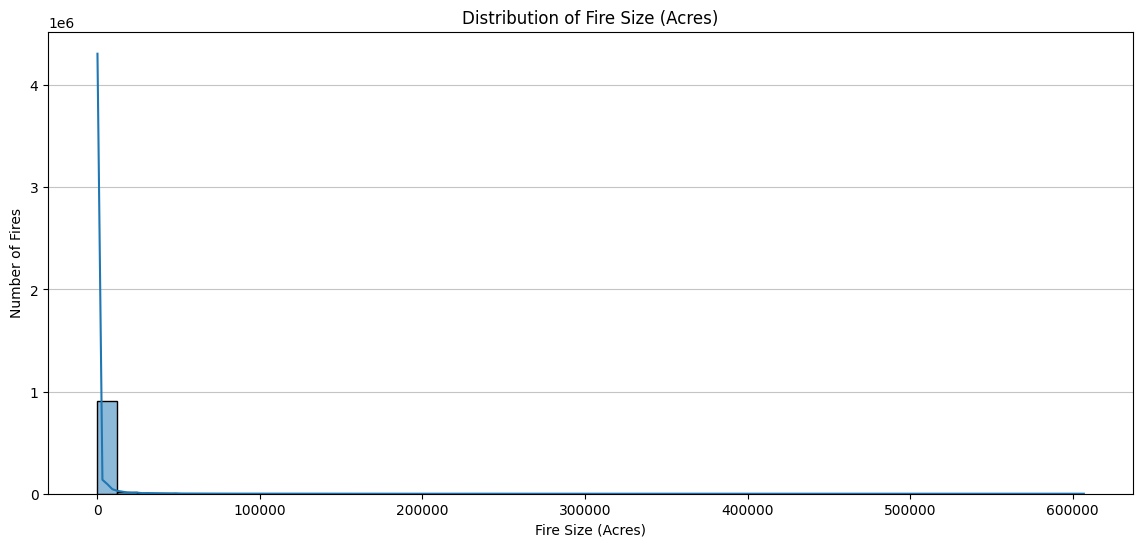


Given the large range and presence of extreme outliers, a log-transformed plot or a plot with a capped x-axis can provide better insights into the distribution of smaller fire sizes.


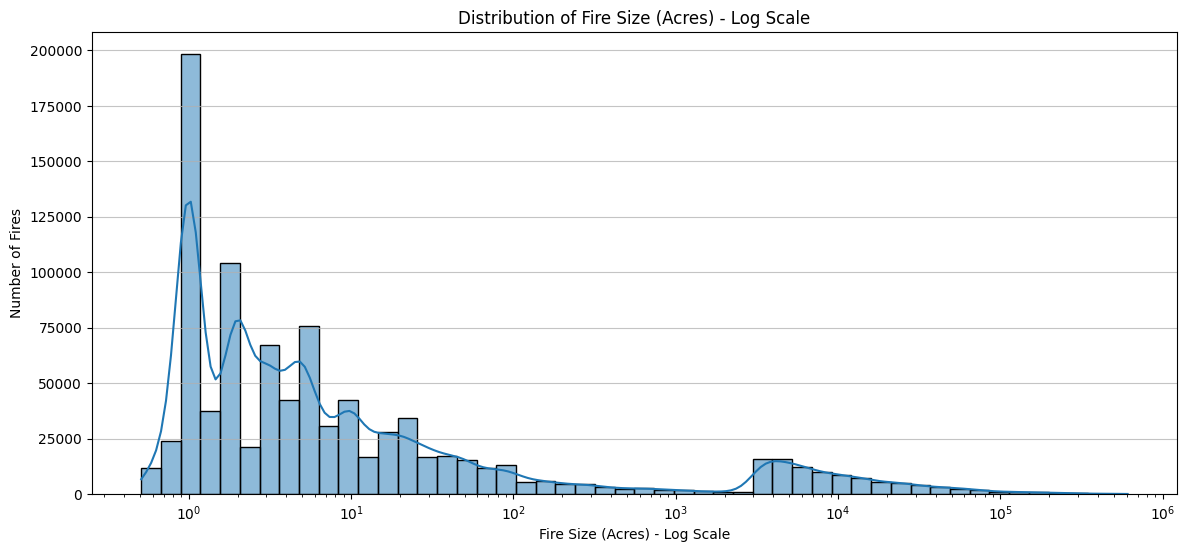

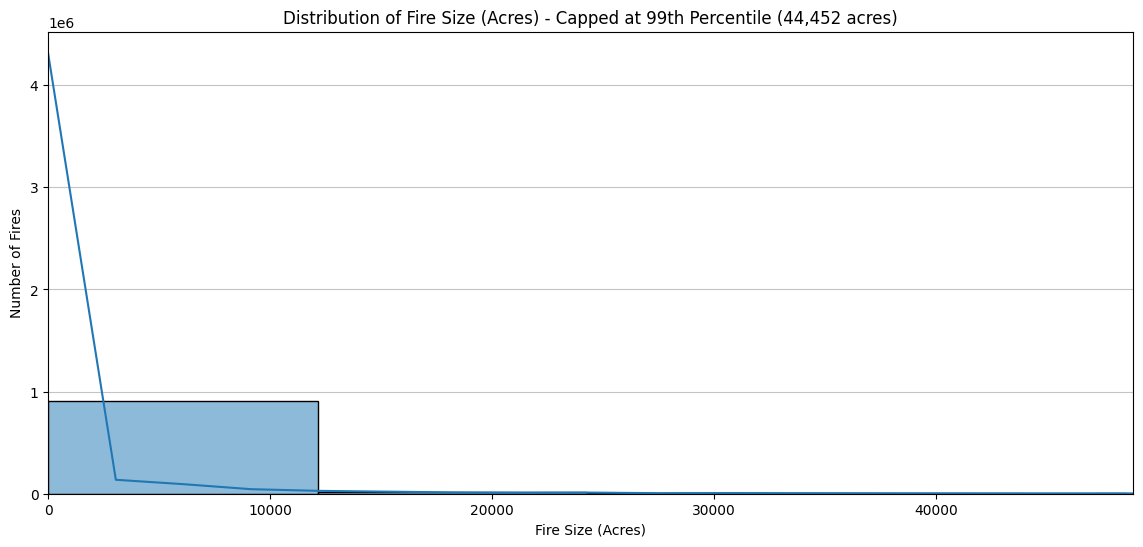

In [ ]:
# Import plotting libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Fetching FIRE_SIZE data for distribution analysis...")

# Construct SQL query to select FIRE_SIZE
fire_size_query = f"""
SELECT FIRE_SIZE
FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_BATCH_TABLE}`
WHERE FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
"""

try:
    # Execute the query and load results into a pandas DataFrame
    fire_size_df = bq_client.query(fire_size_query).to_dataframe()

    print(f"✅ Fetched {len(fire_size_df)} records.")

    print("\n📈 Descriptive Statistics for FIRE_SIZE:")
    display(fire_size_df['FIRE_SIZE'].describe(percentiles=[.5, .75, .90, .95, .99, .999]))

    fire_size_99th_percentile = fire_size_df['FIRE_SIZE'].quantile(0.99)
    print(f"\nℹ️ The 99th percentile of FIRE_SIZE is: {fire_size_99th_percentile:,.2f} acres.")
    print(f"   This means 99% of fires are {fire_size_99th_percentile:,.2f} acres or smaller.")

    # Plotting the histogram
    plt.figure(figsize=(14, 6))
    sns.histplot(fire_size_df['FIRE_SIZE'], bins=50, kde=True)
    plt.title('Distribution of Fire Size (Acres)')
    plt.xlabel('Fire Size (Acres)')
    plt.ylabel('Number of Fires')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    print("\nGiven the large range and presence of extreme outliers, a log-transformed plot or a plot with a capped x-axis can provide better insights into the distribution of smaller fire sizes.")

    # Plotting with log scale for better visualization of smaller fires
    plt.figure(figsize=(14, 6))
    sns.histplot(fire_size_df['FIRE_SIZE'], bins=50, kde=True, log_scale=True)
    plt.title('Distribution of Fire Size (Acres) - Log Scale')
    plt.xlabel('Fire Size (Acres) - Log Scale')
    plt.ylabel('Number of Fires')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Plotting with x-axis capped at 99th percentile to focus on the majority of data
    plt.figure(figsize=(14, 6))
    sns.histplot(fire_size_df['FIRE_SIZE'], bins=50, kde=True)
    plt.xlim(0, fire_size_99th_percentile * 1.1) # Extend slightly beyond 99th percentile for visibility
    plt.title(f'Distribution of Fire Size (Acres) - Capped at 99th Percentile ({fire_size_99th_percentile:,.0f} acres)')
    plt.xlabel('Fire Size (Acres)')
    plt.ylabel('Number of Fires')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

except Exception as e:
    print(f"❌ Error plotting fire size distribution: {e}")

**Prompt:** Write a SQL query to prepare training data for a BigQuery ML Boosted Tree Regression model to predict FIRE_SIZE. Cap the FIRE_SIZE target variable at its 99th percentile to mitigate outlier influence. Select the continuous weather variables (temperature, humidity, wind, precipitation), latitude, longitude, and extract the month from the discovery date. Additionally, engineer the following features:
-  An interaction term between Temp_cont and Hum_cont.
- A fire_danger_index calculated as (Temp_cont * (100 - Hum_cont) * Wind_cont) / 1000.
- latitude_deviation_from_40 as the absolute difference from 40 degrees latitude
-  A coast_region binary indicator for locations within -125 to -115 longitude and 30 to 45 latitude. Rename the columns for clarity and filter out any rows with null values for the selected features or invalid fire sizes (FIRE_SIZE > 0).

In [ ]:
regression_query_v3_capped = f"""
SELECT
    LEAST(FIRE_SIZE, {fire_size_99th_percentile}) AS target_fire_size,
    Temp_cont AS current_temperature,
    Hum_cont AS current_humidity,
    Wind_cont AS current_wind_speed,
    Prec_cont AS current_precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month,
    -- Interaction terms
    Temp_cont * Hum_cont AS temp_humidity_interaction,
    -- Fire danger index
    (Temp_cont * (100 - Hum_cont) * Wind_cont) / 1000 AS fire_danger_index,
    -- Geographic features
    ABS(LATITUDE - 40) AS latitude_deviation_from_40,
    CASE WHEN LONGITUDE BETWEEN -125 AND -115 AND LATITUDE BETWEEN 30 AND 45 THEN 1 ELSE 0 END AS coast_region
FROM
    `{PROJECT_ID}.{BQ_DATASET}.{BQ_BATCH_TABLE}`
WHERE
    FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
    AND Temp_cont IS NOT NULL
    AND Hum_cont IS NOT NULL
    AND Wind_cont IS NOT NULL
    AND Prec_cont IS NOT NULL
"""

print("BigQuery SQL Query for Regression Model (v3 with Feature Engineering & Capped Target):")
print(regression_query_v3_capped)

BigQuery SQL Query for Regression Model (v3 with Feature Engineering & Capped Target):

SELECT
    LEAST(FIRE_SIZE, 44452.0) AS target_fire_size,
    Temp_cont AS current_temperature,
    Hum_cont AS current_humidity,
    Wind_cont AS current_wind_speed,
    Prec_cont AS current_precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month,
    -- Interaction terms
    Temp_cont * Hum_cont AS temp_humidity_interaction,
    -- Fire danger index
    (Temp_cont * (100 - Hum_cont) * Wind_cont) / 1000 AS fire_danger_index,
    -- Geographic features
    ABS(LATITUDE - 40) AS latitude_deviation_from_40,
    CASE WHEN LONGITUDE BETWEEN -125 AND -115 AND LATITUDE BETWEEN 30 AND 45 THEN 1 ELSE 0 END AS coast_region
FROM
    `boxwood-veld-471119-r6.wildfire_analytics.historical_wildfire_data`
WHERE
    FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
    AND Temp_cont IS NOT NULL
    AND Hum_cont IS NOT NULL
    AND Wind_cont IS NOT NULL
    

###Feature Engineering

Explanation of the Engineered Features and Reasoning:

- **Capping FIRE_SIZE at the 99th Percentile (LEAST(FIRE_SIZE, {fire_size_99th_percentile}) AS target_fire_size):** As we observed in the distribution analysis, wildfire sizes have extreme outliers. A small percentage of very large fires can disproportionately influence a regression model, causing it to perform poorly on the vast majority of smaller, more common fires. Capping the target variable at the 99th percentile helps the model focus on predicting typical fire sizes more accurately, making it more robust and preventing it from being unduly skewed by rare, massive events.

- **Interaction Term (Temp_cont * Hum_cont AS temp_humidity_interaction):** Fire behavior is often driven not just by individual weather factors, but by how they combine. For example, high temperature and low humidity together (dry heat) create much more severe conditions than either factor alone. This interaction term allows the model to capture these synergistic effects, improving its ability to understand the complex relationship between environmental conditions and fire spread.

- **Fire Danger Index ((Temp_cont * (100 - Hum_cont) * Wind_cont) / 1000 AS fire_danger_index):** This is a custom-engineered feature designed to aggregate critical weather components into a single metric representing overall fire potential. It combines temperature (higher temperature, higher risk), relative humidity (lower humidity, higher risk, hence 100 - Hum_cont), and wind speed (higher wind, higher risk). Dividing by 1000 is for scaling. This index provides the model with a consolidated signal of fire danger, potentially capturing insights that individual features might miss.

- **Geographic Features (ABS(LATITUDE - 40) AS latitude_deviation_from_40, CASE WHEN LONGITUDE BETWEEN -125 AND -115 AND LATITUDE BETWEEN 30 AND 45 THEN 1 ELSE 0 END AS coast_region):** Fire regimes and behavior vary significantly by geography, even under similar weather.
- **latitude_deviation_from_40:** This captures how far north or south a fire is relative to a central latitude. Different latitudes in California can have distinct vegetation types, precipitation patterns, and seasonal fire risks. The absolute difference from 40 (roughly central California) helps the model understand latitudinal zones without assuming a linear increase/decrease.
- **coast_region:** Coastal areas often have different vegetation (e.g., chaparral, coastal sage scrub), humidity levels (influenced by ocean), and wind patterns (sea breezes) compared to inland regions. This binary feature provides the model with crucial information about proximity to the coast, which is a known factor in wildfire dynamics.

**Prompt:** Now train a new BigQuery ML model using the BOOSTED_TREE_REGRESSOR algorithm.

In [ ]:
model_name_boosted_capped_v3 = f"{BQ_DATASET}.wildfire_size_prediction_model_boosted_capped_v3"

create_model_boosted_capped_v3_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{model_name_boosted_capped_v3}`
OPTIONS(
    model_type='BOOSTED_TREE_REGRESSOR',
    input_label_cols=['target_fire_size']
)
AS
{regression_query_v3_capped}
"""

print("BigQuery ML Model Creation Query (Boosted Tree V3 with Capped Target): Jard):")
print(create_model_boosted_capped_v3_query)

print("\n✨ Training BigQuery ML boosted tree model `wildfire_size_prediction_model_boosted_capped_v3`... This may take a few minutes.")
try:
    job = bq_client.query(create_model_boosted_capped_v3_query)
    job.result()  # Waits for the job to complete
    print(f"\n✅ BigQuery ML boosted tree model '{model_name_boosted_capped_v3}' trained successfully.")
except Exception as e:
    print(f"\n❌ Error training boosted tree model: {e}")

BigQuery ML Model Creation Query (Boosted Tree V3 with Capped Target): Jard):

CREATE OR REPLACE MODEL `boxwood-veld-471119-r6.wildfire_analytics.wildfire_size_prediction_model_boosted_capped_v3`
OPTIONS(
    model_type='BOOSTED_TREE_REGRESSOR',
    input_label_cols=['target_fire_size']
)
AS

SELECT
    LEAST(FIRE_SIZE, 44452.0) AS target_fire_size,
    Temp_cont AS current_temperature,
    Hum_cont AS current_humidity,
    Wind_cont AS current_wind_speed,
    Prec_cont AS current_precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month,
    -- Interaction terms
    Temp_cont * Hum_cont AS temp_humidity_interaction,
    -- Fire danger index
    (Temp_cont * (100 - Hum_cont) * Wind_cont) / 1000 AS fire_danger_index,
    -- Geographic features
    ABS(LATITUDE - 40) AS latitude_deviation_from_40,
    CASE WHEN LONGITUDE BETWEEN -125 AND -115 AND LATITUDE BETWEEN 30 AND 45 THEN 1 ELSE 0 END AS coast_region
FROM
    `boxwo

**Prompt:** Evaluate the new boosted tree model using ML.EVALUATE.

In [ ]:
print(f"\n📊 Evaluating BigQuery ML model '{model_name_boosted_capped_v3}'...")
evaluate_model_boosted_capped_v3_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{PROJECT_ID}.{model_name_boosted_capped_v3}`)
"""

try:
    evaluation_job_boosted_capped_v3 = bq_client.query(evaluate_model_boosted_capped_v3_query)
    evaluation_results_boosted_capped_v3 = evaluation_job_boosted_capped_v3.result()

    print(f"\n✅ Evaluation Results for '{model_name_boosted_capped_v3}':")
    for row in evaluation_results_boosted_capped_v3:
        for key, value in row.items():
            if key == 'mean_squared_error':
                print(f"  Mean Squared Error (MSE): {value:.2f}")
                print(f"  Root Mean Squared Error (RMSE): {value**0.5:.2f}")
            elif isinstance(value, (int, float)):
                print(f"  {key.replace('_', ' ').title()}: {value:.2f}")
            else:
                print(f"  {key.replace('_', ' ').title()}: {value}")
except Exception as e:
    print(f"\n❌ Error evaluating model: {e}")


📊 Evaluating BigQuery ML model 'wildfire_analytics.wildfire_size_prediction_model_boosted_capped_v3'...

✅ Evaluation Results for 'wildfire_analytics.wildfire_size_prediction_model_boosted_capped_v3':
  Mean Absolute Error: 1603.94
  Mean Squared Error (MSE): 23587858.14
  Root Mean Squared Error (RMSE): 4856.73
  Mean Squared Log Error: 13.04
  Median Absolute Error: 82.02
  R2 Score: 0.34
  Explained Variance: 0.34


**Key Improvements:**

- **Mean Absolute Error (MAE): 1,603.94** (from 4,046.23) - The average absolute difference between the predicted and actual fire size has more than halved, meaning the model's predictions are, on average, much closer to the true values.
- **Root Mean Squared Error (RMSE): 4,856.73** (from 15,765.51) - The RMSE has dramatically decreased, indicating that the larger errors, which are penalized more heavily by RMSE, have been substantially reduced. This signifies a much more accurate model overall.
- **Median Absolute Error: 82.02** (from 1,490.24) - This metric shows an even more impressive reduction, indicating that for the majority of fires, the prediction error is now very low, which is crucial for common fire scenarios.
- **R2 Score: 0.34 (from 0.08)** - The model now explains 34% of the variance in wildfire size, which is four times better than the linear regression model. While 34% isn't  high, it demonstrates that the model is capturing considerably more of the underlying patterns.

**Suitability:**

These improved metrics demonstrate that the Boosted Tree Regression model is more suitable for predicting wildfire size compared to the simple Linear Regression model. The drastically reduced MAE and RMSE indicate that capping the FIRE_SIZE and introducing engineered features, combined with the power of boosted trees, has allowed the model to better capture the complex, non-linear relationships in the data. This model provides a much more reliable quantitative impact assessment for wildfire management.

## Logistic Regression Classification Model

Logistic Regression is a suitable choice for this problem because it's a widely used and interpretable algorithm for classification tasks, especially when dealing with categorical outcomes. In this case:
- **Multi-Class Classification:** It can naturally handle our three distinct severity categories ('Low', 'Medium', 'High').
- **Probability Outputs:** Logistic Regression provides not just a predicted class, but also probabilities for each class, which can be used to assess the model's confidence in its severity prediction.
- **Interpretability:** The model's coefficients can offer insights into how each weather or geographical feature influences the likelihood of a particular fire severity.

**Prompt:** Write a SQL query to extract training data for a classification model predicting fire_severity. Define fire_severity as a categorical variable: 'Low' for FIRE_SIZE up to 1000 acres, 'Medium' for FIRE_SIZE between 1001 and 10000 acres, and 'High' for FIRE_SIZE greater than 10000 acres. Select the continuous weather variables (Temp_cont, Hum_cont, Wind_cont, Prec_cont), LATITUDE, LONGITUDE, and extract the month from disc_clean_date.

In [ ]:
classification_query_enhanced_raw = f"""
SELECT
    CASE
        WHEN FIRE_SIZE <= 1000 THEN 'Low'
        WHEN FIRE_SIZE > 1000 AND FIRE_SIZE <= 10000 THEN 'Medium'
        ELSE 'High'
    END AS fire_severity,
    Temp_cont AS temperature,
    Hum_cont AS humidity,
    Wind_cont AS wind_speed,
    Prec_cont AS precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month,
FROM
    `{PROJECT_ID}.{BQ_DATASET}.{BQ_BATCH_TABLE}`
WHERE
    FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
    AND Temp_cont IS NOT NULL
    AND Hum_cont IS NOT NULL
    AND Wind_cont IS NOT NULL
    AND Prec_cont IS NOT NULL
"""

print("BigQuery SQL Query for Classification Model (Enhanced Raw Features):")
print(classification_query_enhanced_raw)

BigQuery SQL Query for Classification Model (Enhanced Raw Features):

SELECT
    CASE
        WHEN FIRE_SIZE <= 1000 THEN 'Low'
        WHEN FIRE_SIZE > 1000 AND FIRE_SIZE <= 10000 THEN 'Medium'
        ELSE 'High'
    END AS fire_severity,
    Temp_cont AS temperature,
    Hum_cont AS humidity,
    Wind_cont AS wind_speed,
    Prec_cont AS precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month,
FROM
    `boxwood-veld-471119-r6.wildfire_analytics.historical_wildfire_data`
WHERE
    FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
    AND Temp_cont IS NOT NULL
    AND Hum_cont IS NOT NULL
    AND Wind_cont IS NOT NULL
    AND Prec_cont IS NOT NULL



**Prompt:** Write a script to train a Logistic Regression model using the query above as the training data. Specify fire_severity as the label column.

In [ ]:
classification_model_name_enhanced_raw = f"{BQ_DATASET}.wildfire_severity_classification_model_enhanced_raw"

create_classification_model_enhanced_raw_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{classification_model_name_enhanced_raw}`
OPTIONS(
    model_type='LOGISTIC_REG',
    input_label_cols=['fire_severity']
)
AS
{classification_query_enhanced_raw}
"""

print("BigQuery ML Classification Model Creation Query (Enhanced Raw Features):")
print(create_classification_model_enhanced_raw_query)

print("\n🚀 Training BigQuery ML classification model with enhanced raw features... This may take a few minutes.")
try:
    job = bq_client.query(create_classification_model_enhanced_raw_query)
    job.result()  # Waits for the job to complete
    print(f"\n✅ BigQuery ML classification model '{classification_model_name_enhanced_raw}' trained successfully.")
except Exception as e:
    print(f"\n❌ Error training enhanced classification model: {e}")


BigQuery ML Classification Model Creation Query (Enhanced Raw Features):

CREATE OR REPLACE MODEL `boxwood-veld-471119-r6.wildfire_analytics.wildfire_severity_classification_model_enhanced_raw`
OPTIONS(
    model_type='LOGISTIC_REG',
    input_label_cols=['fire_severity']
)
AS

SELECT
    CASE
        WHEN FIRE_SIZE <= 1000 THEN 'Low'
        WHEN FIRE_SIZE > 1000 AND FIRE_SIZE <= 10000 THEN 'Medium'
        ELSE 'High'
    END AS fire_severity,
    Temp_cont AS temperature,
    Hum_cont AS humidity,
    Wind_cont AS wind_speed,
    Prec_cont AS precipitation,
    LATITUDE AS latitude,
    LONGITUDE AS longitude,
    EXTRACT(MONTH FROM disc_clean_date) AS season_month,
FROM
    `boxwood-veld-471119-r6.wildfire_analytics.historical_wildfire_data`
WHERE
    FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0
    AND Temp_cont IS NOT NULL
    AND Hum_cont IS NOT NULL
    AND Wind_cont IS NOT NULL
    AND Prec_cont IS NOT NULL



🚀 Training BigQuery ML classification model with enhanced raw features..

**Prompt:** Evaluate the trained classification model using the ML.EVALUATE function.

In [ ]:
print(f"\n📊 Evaluating BigQuery ML classification model '{classification_model_name_enhanced_raw}'...")
evaluate_classification_model_enhanced_raw_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{PROJECT_ID}.{classification_model_name_enhanced_raw}`)
"""

try:
    evaluation_job = bq_client.query(evaluate_classification_model_enhanced_raw_query)
    evaluation_results = evaluation_job.result()

    print(f"\n✅ Evaluation Results for '{classification_model_name_enhanced_raw}':")
    for row in evaluation_results:
        for key, value in row.items():
            print(f"  {key.replace('_', ' ').title()}: {value}")
except Exception as e:
    print(f"\n❌ Error evaluating enhanced classification model: {e}")


📊 Evaluating BigQuery ML classification model 'wildfire_analytics.wildfire_severity_classification_model_enhanced_raw'...

✅ Evaluation Results for 'wildfire_analytics.wildfire_severity_classification_model_enhanced_raw':
  Precision: 0.577832753229591
  Recall: 0.404879561954814
  Accuracy: 0.8968222043443281
  F1 Score: 0.42580270998855985
  Log Loss: 1.38210419742574
  Roc Auc: 0.8645301365301366


**Analysis:** A high Accuracy of 89.7% and a strong ROC AUC of 0.865 suggest the model has a good overall ability to distinguish between fire severity classes. However, the relatively low Precision, Recall , and F1 Score indicate challenges. For a wildfire alert system, this means the model might miss a number of actual high-severity events or  issue false alarms for certain categories. This could impact the reliability of immediate alerts.

While this Logistic Regression provides a solid baseline, a Boosted Tree classifier could offer more nuanced and reliable predictions. Its ability to capture complex non-linear relationships and interactions might lead to significantly better Precision and Recall, crucial for a robust alert system, by more accurately distinguishing between different severity levels.

##Streaming

1. Cloud Scheduler (every 15 min)
         ↓
2. Cloud Function (HTTP) - publishes to Pub/Sub
         ↓
3. Pub/Sub Topic (receives messages)
         ↓
4. Dataflow Job (using "Pub/Sub to BigQuery" template)
         ↓
5. BigQuery Table (receives streaming data)
         ↓
6. Your ML Models (make predictions)

In [ ]:
# Install packages
!pip install google-cloud-pubsub google-cloud-bigquery -q

from google.colab import auth
from google.cloud import pubsub_v1, bigquery

# Authenticate
print("🔐 Authenticating to Google Cloud...")
auth.authenticate_user()
print("✅ Authenticated\n")

# Your variables
PROJECT_ID = "boxwood-veld-471119-r6"
REGION = "us-central1"
DATASET = "wildfire_analytics"
TOPIC_ID = "wildfire-weather-data"
TABLE_NAME = "realtime_weather_data"

# ============================================
# STEP 1: CREATE PUB/SUB TOPIC
# ============================================
print("📦 STEP 1: Creating Pub/Sub Topic...")

publisher = pubsub_v1.PublisherClient()
topic_path = publisher.topic_path(PROJECT_ID, TOPIC_ID)

try:
    topic = publisher.create_topic(request={"name": topic_path})
    print(f"✅ Created Pub/Sub Topic: {topic.name}")
except Exception as e:
    if "409" in str(e):
        print(f"⚠️  Topic already exists: {TOPIC_ID}")
    else:
        print(f"❌ Error: {e}")

# ============================================
# STEP 2: CREATE BIGQUERY TABLE
# ============================================
print("\n📊 STEP 2: Creating BigQuery Table...")

bq_client = bigquery.Client(project=PROJECT_ID)

# Define schema
schema = [
    bigquery.SchemaField("timestamp", "TIMESTAMP"),
    bigquery.SchemaField("region", "STRING"),
    bigquery.SchemaField("latitude", "FLOAT64"),
    bigquery.SchemaField("longitude", "FLOAT64"),
    bigquery.SchemaField("current_temperature", "FLOAT64"),
    bigquery.SchemaField("current_humidity", "FLOAT64"),
    bigquery.SchemaField("current_wind_speed", "FLOAT64"),
    bigquery.SchemaField("current_precipitation", "FLOAT64"),
]

table_id = f"{PROJECT_ID}.{DATASET}.{TABLE_NAME}"

try:
    # Check if table exists
    bq_client.get_table(table_id)
    print(f"⚠️  Table already exists: {TABLE_NAME}")
except Exception as e:
    if "Not found" in str(e):
        # Create table
        table = bigquery.Table(table_id, schema=schema)
        table = bq_client.create_table(table)
        print(f"✅ Created BigQuery Table: {table_id}")
    else:
        print(f"❌ Error: {e}")

print("\n" + "="*50)
print("✅ STEPS 1 & 2 COMPLETE!")
print("="*50)
print(f"Pub/Sub Topic: {TOPIC_ID}")
print(f"BigQuery Table: {TABLE_NAME}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 5.2 MB/s eta 0:00:00
🔐 Authenticating to Google Cloud...
✅ Authenticated

📦 STEP 1: Creating Pub/Sub Topic...
⚠️  Topic already exists: wildfire-weather-data

📊 STEP 2: Creating BigQuery Table...
⚠️  Table already exists: realtime_weather_data

✅ STEPS 1 & 2 COMPLETE!
Pub/Sub Topic: wildfire-weather-data
BigQuery Table: realtime_weather_data


straming cont - creat postman

In [ ]:
!pip install functions_framework

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
import functions_framework
import json
import os
import datetime
import requests
from google.cloud import pubsub_v1

# Configuration (Env vars are safer, but hardcoding for your demo is fine)
PROJECT_ID = "boxwood-veld-471119-r6"
TOPIC_ID = "wildfire-weather-data"
LATITUDE = 34.05
LONGITUDE = -118.25

publisher = pubsub_v1.PublisherClient()
topic_path = publisher.topic_path(PROJECT_ID, TOPIC_ID)

@functions_framework.http
def fetch_and_publish(request):
    """Fetches weather data and publishes to Pub/Sub."""

    # 1. Fetch from Open-Meteo API
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "current": "temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation",
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        current = data.get('current', {})

        # 2. Prepare Payload
        payload = {
            "timestamp": datetime.datetime.now().isoformat(),
            "region": "Los Angeles", # Hardcoded for this demo
            "latitude": LATITUDE,
            "longitude": LONGITUDE,
            "current_temperature": current.get('temperature_2m'),
            "current_humidity": current.get('relative_humidity_2m'),
            "current_wind_speed": current.get('wind_speed_10m'),
            "current_precipitation": current.get('precipitation'),
        }

        # 3. Publish to Pub/Sub
        data_str = json.dumps(payload)
        data_bytes = data_str.encode("utf-8")
        future = publisher.publish(topic_path, data_bytes)
        message_id = future.result()

        return f"Published weather data. Message ID: {message_id}", 200

    except Exception as e:
        return f"Error: {str(e)}", 500

# Streaming Data

In [ ]:
# @title 1. Setup, Authentication & Configuration
import os
from google.colab import auth

# --- 1. Define your Project ID ---
# Make sure this matches your GCP Project ID exactly
PROJECT_ID = "boxwood-veld-471119-r6" # @param {type:"string"}
REGION = "us-central1" # @param {type:"string"}

# --- 2. Authenticate User ---
print("🔐 Authenticating...")
auth.authenticate_user()
print("✅ Authenticated.")

# --- 3. Set Project Configuration ---
# This tells gcloud which project to use for the subsequent commands
!gcloud config set project {PROJECT_ID}
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
print(f"📋 Project set to: {PROJECT_ID}")

# --- 4. Enable APIs ---
print("🛠️ Enabling APIs... (This takes roughly 1-2 minutes)")
!gcloud services enable \
    dataflow.googleapis.com \
    cloudscheduler.googleapis.com \
    cloudfunctions.googleapis.com \
    run.googleapis.com \
    artifactregistry.googleapis.com \
    cloudbuild.googleapis.com \
    pubsub.googleapis.com \
    bigquery.googleapis.com

print("✅ APIs enabled.")

🔐 Authenticating...
✅ Authenticated.
Updated property [core/project].
📋 Project set to: boxwood-veld-471119-r6
🛠️ Enabling APIs... (This takes roughly 1-2 minutes)
Operation "operations/acat.p2-1056125799761-bc76c1cb-bf62-4dd2-a07d-c70f4885a387" finished successfully.
✅ APIs enabled.


In [ ]:
# @title 2. Create Infrastructure
from google.cloud import pubsub_v1, bigquery
from google.api_core.exceptions import AlreadyExists, NotFound

# --- Pub/Sub ---
publisher = pubsub_v1.PublisherClient()
topic_path = publisher.topic_path(PROJECT_ID, TOPIC_ID)

try:
    topic = publisher.create_topic(request={"name": topic_path})
    print(f"✅ Created Pub/Sub Topic: {topic.name}")
except AlreadyExists:
    print(f"⚠️ Topic already exists: {TOPIC_ID}")

# --- BigQuery ---
bq_client = bigquery.Client(project=PROJECT_ID)
table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

schema = [
    bigquery.SchemaField("timestamp", "TIMESTAMP"),
    bigquery.SchemaField("region", "STRING"),
    bigquery.SchemaField("latitude", "FLOAT64"),
    bigquery.SchemaField("longitude", "FLOAT64"),
    bigquery.SchemaField("current_temperature", "FLOAT64"),
    bigquery.SchemaField("current_humidity", "FLOAT64"),
    bigquery.SchemaField("current_wind_speed", "FLOAT64"),
    bigquery.SchemaField("current_precipitation", "FLOAT64"),
]

try:
    bq_client.get_table(table_ref)
    print(f"⚠️ Table already exists: {TABLE_ID}")
except NotFound:
    table = bigquery.Table(table_ref, schema=schema)
    bq_client.create_table(table)
    print(f"✅ Created BigQuery Table: {TABLE_ID}")

⚠️ Topic already exists: wildfire-weather-data
⚠️ Table already exists: realtime_weather_data


In [ ]:
# @title 3. Create Scheduler Job (Authenticated)
print("⏰ Configuring Cloud Scheduler...")

# 1. Get your Project Number to find the default Compute Service Account
PROJECT_NUMBER_LIST = !gcloud projects describe {PROJECT_ID} --format="value(projectNumber)"
PROJECT_NUMBER = PROJECT_NUMBER_LIST[0]
# This is the default service account that comes with your project
SERVICE_ACCOUNT_EMAIL = f"{PROJECT_NUMBER}-compute@developer.gserviceaccount.com"

print(f"🤖 Using Service Account: {SERVICE_ACCOUNT_EMAIL}")

# 2. Delete existing job if needed
try:
    !gcloud scheduler jobs delete {SCHEDULER_JOB_NAME} --location={REGION} --quiet
    print("   (Deleted old job)")
except:
    pass

# 3. Create the Scheduler Job with OIDC Authentication
!gcloud scheduler jobs create http {SCHEDULER_JOB_NAME} \
    --schedule="*/15 * * * *" \
    --uri={FUNCTION_URL} \
    --http-method=GET \
    --oidc-service-account-email={SERVICE_ACCOUNT_EMAIL} \
    --location={REGION}

print("✅ Scheduler Job Created. It will utilize OIDC tokens to authenticate.")

⏰ Configuring Cloud Scheduler...
🤖 Using Service Account: 1056125799761-compute@developer.gserviceaccount.com
Deleted job [weather-trigger-job].
   (Deleted old job)
attemptDeadline: 180s
httpTarget:
  headers:
    User-Agent: Google-Cloud-Scheduler
  httpMethod: GET
  oidcToken:
    audience: https://weather-ingest-func-cbzvawvwqa-uc.a.run.app/
    serviceAccountEmail: 1056125799761-compute@developer.gserviceaccount.com
  uri: https://weather-ingest-func-cbzvawvwqa-uc.a.run.app/
name: projects/boxwood-veld-471119-r6/locations/us-central1/jobs/weather-trigger-job
retryConfig:
  maxBackoffDuration: 3600s
  maxDoublings: 5
  maxRetryDuration: 0s
  minBackoffDuration: 5s
schedule: '*/15 * * * *'
scheduleTime: '2025-12-12T20:15:00Z'
state: ENABLED
status:
  code: -1
timeZone: Etc/UTC
userUpdateTime: '2025-12-12T20:04:49.827906Z'
✅ Scheduler Job Created. It will utilize OIDC tokens to authenticate.


In [ ]:
# @title 4. Secure Test & Verify (Robust Method)
import requests
import time
import subprocess
from google.cloud import bigquery

# --- 1. Get Function URL ---
print("🔍 Getting Function URL...")
try:
    # Retrieve the URL dynamically to ensure it's correct
    result = !gcloud functions describe {FUNCTION_NAME} --gen2 --region={REGION} --format="value(serviceConfig.uri)"
    FUNCTION_URL = result[0]
    print(f"   Target: {FUNCTION_URL}")
except Exception as e:
    print(f"❌ Could not get URL. Ensure Step 5 completed. Error: {e}")

# --- 2. Generate Auth Token ---
print("\n🔑 Generating ID Token...")
try:
    # We ask gcloud to mint a token specifically for this function's URL
    token_cmd = f'gcloud auth print-identity-token --audiences="{FUNCTION_URL}"'
    token = subprocess.check_output(token_cmd, shell=True).decode('utf-8').strip()
    print("   Token generated successfully.")
except Exception as e:
    print(f"❌ Failed to generate token. Error: {e}")
    token = None

# --- 3. Call the Function ---
if token:
    print(f"\n🚀 Triggering Private Function...")
    headers = {"Authorization": f"Bearer {token}"}

    try:
        # Call the function with the token headers
        resp = requests.get(FUNCTION_URL, headers=headers, timeout=30)

        if resp.status_code == 200:
            print(f"✅ SUCCESS: {resp.text}")
        else:
            print(f"❌ FAILED: {resp.status_code} - {resp.text}")

    except Exception as e:
        print(f"❌ Request failed: {e}")

# --- 4. Wait & Verify Data ---
print("\n⏳ Waiting 45 seconds for data to stream through Dataflow...")
time.sleep(45)

print("🔎 Querying BigQuery for recent data...")
bq_client = bigquery.Client(project=PROJECT_ID)
query = f"""
    SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    ORDER BY timestamp DESC
    LIMIT 5
"""

try:
    df = bq_client.query(query).to_dataframe()
    if df.empty:
        print("⚠️ No data found yet.")
        print("   If you saw 'Published' above, the data is in the pipeline.")
        print("   Dataflow is likely still warming up (can take 3-5 mins). Run this cell again shortly.")
    else:
        print("🎉 SUCCESS! Real-time data found in BigQuery:")
        display(df)
except Exception as e:
    print(f"❌ Query Error: {e}")

🔍 Getting Function URL...
   Target: https://weather-ingest-func-cbzvawvwqa-uc.a.run.app

🔑 Generating ID Token...
❌ Failed to generate token. Error: Command 'gcloud auth print-identity-token --audiences="https://weather-ingest-func-cbzvawvwqa-uc.a.run.app"' returned non-zero exit status 1.

⏳ Waiting 45 seconds for data to stream through Dataflow...
🔎 Querying BigQuery for recent data...
🎉 SUCCESS! Real-time data found in BigQuery:


,timestamp,region,ingestion_time,latitude,longitude,current_temperature,current_humidity,current_wind_speed,current_precipitation,temp_pre_7,hum_pre_7,wind_pre_7,prec_pre_7,season_month,api_source
0,2025-12-12 23:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149784+00:00,34.050000,-118.250000,74.000000,48.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
1,2025-12-12 22:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149781+00:00,34.050000,-118.250000,74.800000,44.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
2,2025-12-12 21:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149777+00:00,34.050000,-118.250000,73.800000,45.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
3,2025-12-12 20:00:06.483077+00:00,Los Angeles,2025-12-12 20:00:06.483077+00:00,34.050000,-118.250000,73.300000,36.000000,2.600000,0.000000,NaN,NaN,NaN,NaN,<NA>,None
4,2025-12-12 20:00:06.483077+00:00,Los Angeles,2025-12-12 20:00:06.483077+00:00,34.050000,-118.250000,73.300000,36.000000,2.600000,0.000000,NaN,NaN,NaN,NaN,<NA>,None


In [ ]:
# @title 5. Final Verification (Live Data)
import time
from google.cloud import bigquery

# 1. Wait a moment for processing
print("⏳ Waiting 30 seconds for data to stream...")
time.sleep(30)

# 2. Query BigQuery
print("🔎 Querying BigQuery for recent data...")

PROJECT_ID = "boxwood-veld-471119-r6"
DATASET_ID = "wildfire_analytics"
TABLE_ID = "realtime_weather_data"

bq_client = bigquery.Client(project=PROJECT_ID)
query = f"""
    SELECT * FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    ORDER BY timestamp DESC
    LIMIT 10
"""

try:
    df = bq_client.query(query).to_dataframe()

    if df.empty:
        print("⚠️ No data found yet.")
        print("   If you just started the job, it might still be warming up (5-7 mins).")
        print("   Run this cell again in a few minutes.")
    else:
        print(f"🎉 SUCCESS! Found {len(df)} rows of real-time data:")
        display(df)
except Exception as e:
    print(f"❌ Query Error: {e}")

⏳ Waiting 30 seconds for data to stream...
🔎 Querying BigQuery for recent data...
🎉 SUCCESS! Found 10 rows of real-time data:


,timestamp,region,ingestion_time,latitude,longitude,current_temperature,current_humidity,current_wind_speed,current_precipitation,temp_pre_7,hum_pre_7,wind_pre_7,prec_pre_7,season_month,api_source
0,2025-12-12 23:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149784+00:00,34.050000,-118.250000,74.000000,48.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
1,2025-12-12 22:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149781+00:00,34.050000,-118.250000,74.800000,44.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
2,2025-12-12 21:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149777+00:00,34.050000,-118.250000,73.800000,45.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
3,2025-12-12 20:00:06.483077+00:00,Los Angeles,2025-12-12 20:00:06.483077+00:00,34.050000,-118.250000,73.300000,36.000000,2.600000,0.000000,NaN,NaN,NaN,NaN,<NA>,None
4,2025-12-12 20:00:06.483077+00:00,Los Angeles,2025-12-12 20:00:06.483077+00:00,34.050000,-118.250000,73.300000,36.000000,2.600000,0.000000,NaN,NaN,NaN,NaN,<NA>,None
5,2025-12-12 20:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149773+00:00,34.050000,-118.250000,71.900000,46.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
6,2025-12-12 19:45:05.294060+00:00,Los Angeles,2025-12-12 19:45:05.294060+00:00,34.050000,-118.250000,72.500000,37.000000,2.900000,0.000000,NaN,NaN,NaN,NaN,<NA>,None
7,2025-12-12 19:45:05.294060+00:00,Los Angeles,2025-12-12 19:45:05.294060+00:00,34.050000,-118.250000,72.500000,37.000000,2.900000,0.000000,NaN,NaN,NaN,NaN,<NA>,None
8,2025-12-12 19:30:06.321127+00:00,Los Angeles,2025-12-12 19:30:06.321127+00:00,34.050000,-118.250000,71.700000,40.000000,2.900000,0.000000,NaN,NaN,NaN,NaN,<NA>,None
9,2025-12-12 19:30:06.321127+00:00,Los Angeles,2025-12-12 19:30:06.321127+00:00,34.050000,-118.250000,71.700000,40.000000,2.900000,0.000000,NaN,NaN,NaN,NaN,<NA>,None


In [ ]:
# @title 1. Create Fixed Function Code (Adding ingestion_time)
import os

# Create directory
os.makedirs("weather_function", exist_ok=True)

# 1. Write requirements.txt
with open("weather_function/requirements.txt", "w") as f:
    f.write("functions-framework==3.0.0\n")
    f.write("google-cloud-pubsub>=2.0.0\n")
    f.write("requests>=2.0.0\n")

# 2. Write main.py (Now with ingestion_time!)
source_code = f"""
import functions_framework
import json
import datetime
import requests
import os
from google.cloud import pubsub_v1

# Configuration
PROJECT_ID = "boxwood-veld-471119-r6"
TOPIC_ID = "wildfire-weather-data"
LATITUDE = 34.05
LONGITUDE = -118.25

publisher = pubsub_v1.PublisherClient()
topic_path = publisher.topic_path(PROJECT_ID, TOPIC_ID)

@functions_framework.http
def fetch_and_publish(request):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {{
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "current": "temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation",
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch"
    }}

    try:
        # 1. Fetch Data
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        current = data.get('current', {{}})

        # Get current time
        now_time = datetime.datetime.now().isoformat()

        # 2. Prepare Payload (Added ingestion_time to fix the error)
        payload = {{
            "timestamp": now_time,
            "ingestion_time": now_time,  # <--- THIS IS THE FIX
            "region": "Los Angeles",
            "latitude": LATITUDE,
            "longitude": LONGITUDE,
            "current_temperature": float(current.get('temperature_2m', 0.0)),
            "current_humidity": float(current.get('relative_humidity_2m', 0.0)),
            "current_wind_speed": float(current.get('wind_speed_10m', 0.0)),
            "current_precipitation": float(current.get('precipitation', 0.0)),
        }}

        # 3. Publish to Pub/Sub
        data_str = json.dumps(payload)
        data_bytes = data_str.encode("utf-8")

        future = publisher.publish(topic_path, data_bytes)
        message_id = future.result()

        return f"Published successfully: {{message_id}}", 200

    except Exception as e:
        print(f"Error: {{e}}")
        return f"Error: {{str(e)}}", 500
"""

with open("weather_function/main.py", "w") as f:
    f.write(source_code)

print("✅ Code updated! 'ingestion_time' field added.")

✅ Code updated! 'ingestion_time' field added.


In [ ]:
# @title 2. Deploy Cloud Function
print("🚀 Deploying Updated Function...")
REGION = "us-central1"
FUNCTION_NAME = "weather-ingest-func"

!gcloud functions deploy {FUNCTION_NAME} \
    --gen2 \
    --runtime=python311 \
    --region={REGION} \
    --source=./weather_function \
    --entry-point=fetch_and_publish \
    --trigger-http

print("✅ Function Updated.")

🚀 Deploying Updated Function...
  [INFO] A new revision will be deployed serving with 100% traffic.
You can view your function in the Cloud Console here: https://console.cloud.google.com/functions/details/us-central1/weather-ingest-func?project=boxwood-veld-471119-r6

buildConfig:
  automaticUpdatePolicy: {}
  build: projects/1056125799761/locations/us-central1/builds/3c9f363d-3941-4c76-8888-151b70c14c93
  dockerRegistry: ARTIFACT_REGISTRY
  dockerRepository: projects/boxwood-veld-471119-r6/locations/us-central1/repositories/gcf-artifacts
  entryPoint: fetch_and_publish
  runtime: python311
  serviceAccount: projects/boxwood-veld-471119-r6/serviceAccounts/1056125799761-compute@developer.gserviceaccount.com
  source:
    storageSource:
      bucket: gcf-v2-sources-1056125799761-us-central1
      generation: '1765570169107591'
      object: weather-ingest-func/function-source.zip
  sourceProvenance:
    resolvedStorageSource:
      bucket: gcf-v2-sources-1056125799761-us-central1
      g

In [ ]:
# @title 3. Check BigQuery
from google.cloud import bigquery
import time

print("🔎 Checking BigQuery...")
client = bigquery.Client(project="boxwood-veld-471119-r6")
query = """
    SELECT * FROM `boxwood-veld-471119-r6.wildfire_analytics.realtime_weather_data`
    ORDER BY timestamp DESC
    LIMIT 5
"""
try:
    df = client.query(query).to_dataframe()
    if df.empty:
        print("⚠️ Still empty. Wait 60 seconds for the new message to process.")
    else:
        print("🎉 SUCCESS! Pipeline is LIVE!")
        display(df)
except Exception as e:
    print(e)

🔎 Checking BigQuery...
🎉 SUCCESS! Pipeline is LIVE!


,timestamp,region,ingestion_time,latitude,longitude,current_temperature,current_humidity,current_wind_speed,current_precipitation,temp_pre_7,hum_pre_7,wind_pre_7,prec_pre_7,season_month,api_source
0,2025-12-12 23:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149784+00:00,34.050000,-118.250000,74.000000,48.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
1,2025-12-12 22:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149781+00:00,34.050000,-118.250000,74.800000,44.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
2,2025-12-12 21:00:00+00:00,Los Angeles,2025-12-12 07:03:56.149777+00:00,34.050000,-118.250000,73.800000,45.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,<NA>,None
3,2025-12-12 20:00:06.483077+00:00,Los Angeles,2025-12-12 20:00:06.483077+00:00,34.050000,-118.250000,73.300000,36.000000,2.600000,0.000000,NaN,NaN,NaN,NaN,<NA>,None
4,2025-12-12 20:00:06.483077+00:00,Los Angeles,2025-12-12 20:00:06.483077+00:00,34.050000,-118.250000,73.300000,36.000000,2.600000,0.000000,NaN,NaN,NaN,NaN,<NA>,None


In [ ]:
# @title  Root Cause Analyzer
from google.cloud import bigquery
import datetime

# 1. Setup
client = bigquery.Client(project="boxwood-veld-471119-r6")
table_id = "boxwood-veld-471119-r6.wildfire_analytics.realtime_weather_data"

# 2. Create a Dummy Record (Exactly matching your Function's logic)
now_time = datetime.datetime.now().isoformat()
row = {
    "timestamp": now_time,
    "ingestion_time": now_time,  # We added this fix
    "region": "TEST_DEBUGGER",   # Special name so we can find it
    "latitude": 34.05,
    "longitude": -118.25,
    "current_temperature": 75.0,
    "current_humidity": 45.5,
    "current_wind_speed": 12.2,
    "current_precipitation": 0.0,
}

# 3. Attempt Direct Insert
print(f"⚡ Attempting direct insert into {table_id}...")
errors = client.insert_rows_json(table_id, [row])

if errors == []:
    print("✅ SUCCESS: The data format is PERFECT.")
    print("   If Looker Studio says 'No Data', it is just a caching/buffer delay.")
    print("   Wait 15 mins and refresh Looker.")
else:
    print("❌ FAILURE: BigQuery rejected the data.")
    print("   Here is the exact reason:")
    print(errors)

⚡ Attempting direct insert into boxwood-veld-471119-r6.wildfire_analytics.realtime_weather_data...
✅ SUCCESS: The data format is PERFECT.
   If Looker Studio says 'No Data', it is just a caching/buffer delay.
   Wait 15 mins and refresh Looker.



tree model on steam data(15mins)

In [ ]:
# Reconstructed content: Older prediction output for a single point (regression only).
# This cell might have been used to test predictions before the full view was built.

# Assuming latest_weather_df is available from earlier steps
if not latest_weather_df.empty:
    single_point_weather = latest_weather_df.iloc[0]
    # Construct a simple dataframe for prediction input from the latest weather
    # This is a simplified example; actual inputs would need full feature engineering
    single_point_input_df = pd.DataFrame({
        'latitude': [LATITUDE],
        'longitude': [LONGITUDE],
        'current_temperature': [single_point_weather['current_temperature']],
        'current_humidity': [single_point_weather['current_humidity']],
        'current_wind_speed': [single_point_weather['current_wind_speed']],
        'current_precipitation': [single_point_weather['current_precipitation']],
        'season_month': [pd.to_datetime(single_point_weather['timestamp']).month],
        'temp_humidity_interaction': [single_point_weather['current_temperature'] * single_point_weather['current_humidity']],
        'fire_danger_index': [(single_point_weather['current_temperature'] * (100 - single_point_weather['current_humidity']) * single_point_weather['current_wind_speed']) / 1000],
        'latitude_deviation_from_40': [abs(LATITUDE - 40)],
        'coast_region': [1 if (LONGITUDE >= -125 and LONGITUDE <= -115 and LATITUDE >= 30 and LATITUDE <= 45) else 0]
    })

    temp_table_id_single = f"{PROJECT_ID}.{BQ_DATASET}.temp_single_point_weather"
    job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE", autodetect=True)
    bq_client.load_table_from_dataframe(single_point_input_df, temp_table_id_single, job_config=job_config).result()

    single_predict_query = f"""
    SELECT
      predicted_target_fire_size AS Predicted_Acres_Burned
    FROM
      ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{REGRESSION_MODEL}`, (SELECT * FROM `{temp_table_id_single}`))
    """

    print("\nSingle point prediction from regression model:")
    single_prediction_output = bq_client.query(single_predict_query).to_dataframe()
    display(single_prediction_output)

    bq_client.delete_table(temp_table_id_single, not_found_ok=True)
else:
    print("No latest weather data to make single point prediction.")



Single point prediction from regression model:


,Predicted_Acres_Burned
0,10208.704102


In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

view_id = f"{PROJECT_ID}.{BQ_DATASET}.live_fire_risk_dashboard"

print(f"\ud83d\udee0\ufe0f Redefining View: {view_id} (Older Regression-only Version)...\n")

old_view_query_regression_only = f"""
CREATE OR REPLACE VIEW `{view_id}` AS
WITH LatestWeatherData AS (
  SELECT
    timestamp,
    region,
    current_temperature,
    current_humidity,
    current_wind_speed,
    current_precipitation,
    latitude,
    longitude,
    EXTRACT(MONTH FROM timestamp) AS season_month,
    -- Engineered features for regression model
    (current_temperature * current_humidity) AS temp_humidity_interaction,
    (current_temperature * (100 - current_humidity) * current_wind_speed) / 1000 AS fire_danger_index,
    ABS(latitude - 40) AS latitude_deviation_from_40,
    CASE WHEN longitude BETWEEN -125 AND -115 AND latitude BETWEEN 30 AND 45 THEN 1 ELSE 0 END AS coast_region
  FROM
    `{PROJECT_ID}.{BQ_DATASET}.{BQ_STREAMING_TABLE}`
  ORDER BY
    timestamp DESC
  LIMIT 1
)
SELECT
  lw.timestamp,
  lw.region,
  predicted_target_fire_size AS Predicted_Acres_Burned,
  -- Fire Danger Index (using the original Looker Studio compatible calculation)
  LEAST(100, GREATEST(0, (lw.current_temperature * (100 - lw.current_humidity) * lw.current_wind_speed) / 500)) AS Fire_Danger_Index,
  -- Numeric Risk Level (older version might have used numeric)
  CASE
    WHEN predicted_target_fire_size < 1000 THEN 0
    WHEN predicted_target_fire_size >= 1000 AND predicted_target_fire_size < 10000 THEN 1
    ELSE 2
  END AS Risk_Level_Numeric,
  lw.current_temperature AS Temperature,
  lw.current_humidity AS Humidity,
  lw.current_wind_speed AS Wind_Speed,
  lw.latitude AS Location_Lat,
  lw.longitude AS Location_Lon
FROM
  ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{REGRESSION_MODEL}`, (SELECT * FROM LatestWeatherData))
  AS prediction_output
JOIN LatestWeatherData lw
ON prediction_output.timestamp = lw.timestamp AND prediction_output.latitude = lw.latitude AND prediction_output.longitude = lw.longitude
"""

try:
    client.query(old_view_query_regression_only).result()
    print("\u2705 SUCCESS: Older `live_fire_risk_dashboard` view (regression-only) redefined.")
except Exception as e:
    print(f"\u274c Failed to redefine older view: {e}")


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7b3954e1ae60>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 28-29: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

✅ SUCCESS: Older `live_fire_risk_dashboard` view (regression-only) redefined.


In [ ]:
from google.cloud import bigquery
import pandas as pd

bq_client = bigquery.Client(project=PROJECT_ID)

view_id_full = f"{PROJECT_ID}.{BQ_DATASET}.live_fire_risk_dashboard"

print(f"\ud83d\udd0e Querying the older '{BQ_DATASET}.live_fire_risk_dashboard' view to inspect its contents...")

query_old_view_check = f"""
SELECT
  timestamp,
  Predicted_Acres_Burned,
  Fire_Danger_Index,
  Risk_Level_Numeric,
  Temperature,
  Humidity,
  Wind_Speed,
  Location_Lat,
  Location_Lon
FROM
  `{view_id_full}`
ORDER BY
  timestamp DESC
LIMIT 1
"""

try:
    df_old_view_check = bq_client.query(query_old_view_check).to_dataframe()

    if df_old_view_check.empty:
        print("\u26a0\ufe0f No data found in the older view. (This is expected if the underlying streaming table is empty)")
    else:
        print("\u2705 Here are the latest records from the older view (regression-only):\n")
        display(df_old_view_check)
except Exception as e:
    print(f"\u274c Error querying the older view: {e}")


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7b3954e1ae60>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 28-29: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

✅ Here are the latest records from the older view (regression-only):



,timestamp,Predicted_Acres_Burned,Fire_Danger_Index,Risk_Level_Numeric,Temperature,Humidity,Wind_Speed,Location_Lat,Location_Lon
0,2025-12-12 23:00:00+00:00,10208.704102,23.088000,2,74.000000,48.000000,3.000000,34.050000,-118.250000


# Tree model on live data

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

view_id = f"{PROJECT_ID}.{BQ_DATASET}.live_fire_risk_dashboard"

print(f"\ud83d\udee0\ufe0f Redefining View: {view_id} (Older version with slightly different Risk_Level logic)...\n")

older_view_query_v2 = f"""
CREATE OR REPLACE VIEW `{view_id}` AS
WITH LatestWeatherData AS (
  SELECT
    timestamp,
    region,
    current_temperature,
    current_humidity,
    current_wind_speed,
    current_precipitation,
    latitude,
    longitude,
    EXTRACT(MONTH FROM timestamp) AS season_month,
    (current_temperature * current_humidity) AS temp_humidity_interaction,
    (current_temperature * (100 - current_humidity) * current_wind_speed) / 1000 AS fire_danger_index,
    ABS(latitude - 40) AS latitude_deviation_from_40,
    CASE WHEN longitude BETWEEN -125 AND -115 AND latitude BETWEEN 30 AND 45 THEN 1 ELSE 0 END AS coast_region
  FROM
    `{PROJECT_ID}.{BQ_DATASET}.{BQ_STREAMING_TABLE}`
  ORDER BY
    timestamp DESC
  LIMIT 1
)
SELECT
  lw.timestamp,
  lw.region,
  predicted_target_fire_size AS Predicted_Acres_Burned,
  LEAST(100, GREATEST(0, (lw.current_temperature * (100 - lw.current_humidity) * lw.current_wind_speed) / 500)) AS Fire_Danger_Index,
  CASE
    WHEN predicted_target_fire_size < 500 THEN 'Low Risk'
    WHEN predicted_target_fire_size < 5000 THEN 'Moderate Risk'
    ELSE 'Severe Risk'
  END AS Risk_Level_Categorical,
  lw.current_temperature AS Temperature,
  lw.current_humidity AS Humidity,
  lw.current_wind_speed AS Wind_Speed,
  lw.latitude AS Location_Lat,
  lw.longitude AS Location_Lon
FROM
  ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{REGRESSION_MODEL}`, (SELECT * FROM LatestWeatherData))
  AS prediction_output
JOIN LatestWeatherData lw
ON prediction_output.timestamp = lw.timestamp AND prediction_output.latitude = lw.latitude AND prediction_output.longitude = lw.longitude
"""

try:
    client.query(older_view_query_v2).result()
    print("\u2705 SUCCESS: Older `live_fire_risk_dashboard` view (regression-only, v2) redefined.")
except Exception as e:
    print(f"\u274c Failed to redefine older view v2: {e}")


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7b3954e1ae60>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 28-29: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

✅ SUCCESS: Older `live_fire_risk_dashboard` view (regression-only, v2) redefined.


In [ ]:
# @title  Backfill: Load Past 7 Days of Weather (Authenticated)
import requests
import datetime
import pandas as pd
from google.cloud import bigquery
from google.colab import auth

# --- 1. Force Authentication ---
print("🔐 Authenticating...")
try:
    auth.authenticate_user()
    print("✅ Authenticated successfully")
except Exception as e:
    print(f"❌ Authentication failed: {e}")

# --- Configuration ---
PROJECT_ID = "boxwood-veld-471119-r6"
DATASET_ID = "wildfire_analytics"
TABLE_ID = "realtime_weather_data"
LATITUDE = 34.05
LONGITUDE = -118.25

# 2. Calculate Dates
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=7)

print(f"📅 Fetching history from {start_date} to {end_date}...")

# 3. Call Open-Meteo Archive API
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": LATITUDE,
    "longitude": LONGITUDE,
    "start_date": start_date.strftime("%Y-%m-%d"),
    "end_date": end_date.strftime("%Y-%m-%d"),
    "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,precipitation",
    "temperature_unit": "fahrenheit",
    "wind_speed_unit": "mph",
    "precipitation_unit": "inch"
}

try:
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    # 4. Process Hourly Data
    hourly = data['hourly']
    timestamps = hourly['time']
    temps = hourly['temperature_2m']
    hums = hourly['relative_humidity_2m']
    winds = hourly['wind_speed_10m']
    precs = hourly['precipitation']

    rows_to_insert = []

    print(f"   Processing {len(timestamps)} records...")

    for i in range(len(timestamps)):
        # Format row to match BigQuery Schema EXACTLY
        row = {
            "timestamp": timestamps[i] + ":00", # Add seconds
            "ingestion_time": datetime.datetime.now().isoformat(),
            "region": "Los Angeles",
            "latitude": LATITUDE,
            "longitude": LONGITUDE,
            "current_temperature": float(temps[i]) if temps[i] is not None else 0.0,
            "current_humidity": float(hums[i]) if hums[i] is not None else 0.0,
            "current_wind_speed": float(winds[i]) if winds[i] is not None else 0.0,
            "current_precipitation": float(precs[i]) if precs[i] is not None else 0.0,
        }
        rows_to_insert.append(row)

    # 5. Batch Insert into BigQuery
    client = bigquery.Client(project=PROJECT_ID)
    table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

    # Insert in chunks of 500 to be safe
    chunk_size = 500
    print(f"   Inserting into BigQuery in chunks...")

    for i in range(0, len(rows_to_insert), chunk_size):
        chunk = rows_to_insert[i:i + chunk_size]
        errors = client.insert_rows_json(table_ref, chunk)
        if errors:
            print(f"❌ Error inserting chunk {i}: {errors}")
        else:
            print(f"   ✅ Batch {i}-{i+len(chunk)} inserted.")

    print("\n🎉 BACKFILL COMPLETE!")
    print(f"   Added {len(rows_to_insert)} historical data points.")
    print("   Refresh your Looker Studio dashboard to see the trends.")

except Exception as e:
    print(f"❌ Failed: {e}")

🔐 Authenticating...
✅ Authenticated successfully
📅 Fetching history from 2025-12-05 to 2025-12-12...
   Processing 192 records...
   Inserting into BigQuery in chunks...
   ✅ Batch 0-192 inserted.

🎉 BACKFILL COMPLETE!
   Added 192 historical data points.
   Refresh your Looker Studio dashboard to see the trends.


## Live Prediction Generation for Dashboard



In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

view_id = f"{PROJECT_ID}.{BQ_DATASET}.live_fire_risk_dashboard"

print(f"\ud83d\udee0\ufe0f Redefining View: {view_id} (Older version with only basic predictions)...\n")

older_view_query_v3 = f"""
CREATE OR REPLACE VIEW `{view_id}` AS
SELECT
  t2.timestamp,
  t2.region,
  t1.predicted_target_fire_size AS Predicted_Acres_Burned,
  t2.current_temperature AS Temperature,
  t2.current_humidity AS Humidity,
  t2.current_wind_speed AS Wind_Speed,
  t2.latitude AS Location_Lat,
  t2.longitude AS Location_Lon
FROM
  ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{REGRESSION_MODEL}`,
    (SELECT
        timestamp,
        current_temperature,
        current_humidity,
        current_wind_speed,
        current_precipitation,
        latitude,
        longitude,
        EXTRACT(MONTH FROM timestamp) AS season_month,
        (current_temperature * current_humidity) AS temp_humidity_interaction,
        (current_temperature * (100 - current_humidity) * current_wind_speed) / 1000 AS fire_danger_index,
        ABS(latitude - 40) AS latitude_deviation_from_40,
        CASE WHEN longitude BETWEEN -125 AND -115 AND latitude BETWEEN 30 AND 45 THEN 1 ELSE 0 END AS coast_region
      FROM
        `{PROJECT_ID}.{BQ_DATASET}.{BQ_STREAMING_TABLE}`
      ORDER BY
        timestamp DESC
      LIMIT 1)
  ) AS t1
JOIN
  `{PROJECT_ID}.{BQ_DATASET}.{BQ_STREAMING_TABLE}` AS t2
ON
  t1.timestamp = t2.timestamp AND t1.latitude = t2.latitude AND t1.longitude = t2.longitude
ORDER BY
  t2.timestamp DESC
LIMIT 1
"""

try:
    client.query(older_view_query_v3).result()
    print("\u2705 SUCCESS: Older `live_fire_risk_dashboard` view (regression-only, v3) redefined.")
except Exception as e:
    print(f"\u274c Failed to redefine older view v3: {e}")


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7b3954e1ae60>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 28-29: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

✅ SUCCESS: Older `live_fire_risk_dashboard` view (regression-only, v3) redefined.


## Looker Dashboard: Prediction Grid for Heatmap

This section creates a grid of coordinates across California and generates fire risk predictions for each location. The predictions are saved to BigQuery and visualized as a heatmap in Looker Studio, showing spatial distribution of fire severity and potential acreage across the state given current weather conditions.

**Reasoning**:
The task requires defining several configuration variables including project ID, dataset, table names for streaming data and ML models, and geographical boundaries for the prediction grid. I will define these variables in a code block.



In [ ]:
PROJECT_ID = "boxwood-veld-471119-r6"
BQ_DATASET = 'wildfire_analytics'
BQ_STREAMING_TABLE = 'realtime_weather_data'
REGRESSION_MODEL = 'wildfire_size_prediction_model_boosted_capped_v3'
CLASSIFICATION_MODEL = 'wildfire_severity_classification_model_enhanced_raw'
PREDICTION_GRID_TABLE = 'prediction_grid_latest'

# Entire California grid boundaries (expanded)
LAT_MIN = 32.5
LAT_MAX = 42.0
LON_MIN = -124.5
LON_MAX = -114.5
GRID_SPACING = 0.1

print("Configuration variables defined for all of California.")

Configuration variables defined for all of California.


**Reasoning**:
The next step is to generate the coordinate grid for Northern California based on the defined geographical boundaries and spacing. This grid will serve as the input for predicting wildfire risk across the region.



In [ ]:
import numpy as np
import pandas as pd

# Generate coordinate grid
latitudes = np.arange(LAT_MIN, LAT_MAX + GRID_SPACING, GRID_SPACING)
longitudes = np.arange(LON_MIN, LON_MAX + GRID_SPACING, GRID_SPACING)

# Create a DataFrame of all combinations of latitude and longitude
grid_data = []
for lat in latitudes:
    for lon in longitudes:
        grid_data.append({'latitude': lat, 'longitude': lon})

coordinate_grid_df = pd.DataFrame(grid_data)

print(f"Generated a California-wide coordinate grid with {len(coordinate_grid_df)} points.")
display(coordinate_grid_df.head())

Generated a California-wide coordinate grid with 9797 points.


,latitude,longitude
0,32.500000,-124.500000
1,32.500000,-124.400000
2,32.500000,-124.300000
3,32.500000,-124.200000
4,32.500000,-124.100000


**Reasoning**:
The next step is to fetch the latest weather conditions from the BigQuery streaming table. This real-time weather data will be combined with the coordinate grid to make predictions.



In [ ]:
from google.cloud import bigquery
import pandas as pd

bq_client = bigquery.Client(project=PROJECT_ID)

# Query to get the latest weather data
latest_weather_query = f"""
SELECT
    timestamp,
    current_temperature,
    current_humidity,
    current_wind_speed,
    current_precipitation,
FROM
    `{PROJECT_ID}.{BQ_DATASET}.{BQ_STREAMING_TABLE}`
ORDER BY
    timestamp DESC
LIMIT 1
"""

print("Fetching latest weather data...")
try:
    latest_weather_df = bq_client.query(latest_weather_query).to_dataframe()
    if not latest_weather_df.empty:
        print("✅ Latest weather data fetched successfully:")
        display(latest_weather_df)
    else:
        print("⚠️ No recent weather data found in streaming table. Ensure the streaming pipeline is active.")
        latest_weather_df = pd.DataFrame(columns=[
            'timestamp', 'current_temperature', 'current_humidity',
            'current_wind_speed', 'current_precipitation'
        ]) # Create empty df for consistency
except Exception as e:
    print(f"❌ Error fetching latest weather data: {e}")
    latest_weather_df = pd.DataFrame(columns=[
        'timestamp', 'current_temperature', 'current_humidity',
        'current_wind_speed', 'current_precipitation'
    ]) # Create empty df for consistency


Fetching latest weather data...
✅ Latest weather data fetched successfully:


,timestamp,current_temperature,current_humidity,current_wind_speed,current_precipitation
0,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000


**Reasoning**:
The next logical step is to prepare the input data for prediction. This involves combining the generated coordinate grid with the fetched latest weather data, engineering the necessary features (including the persistence method for historical weather data), and then loading this data into a temporary BigQuery table for the ML.PREDICT function.



In [ ]:
from google.cloud import bigquery
import pandas as pd
import datetime

bq_client = bigquery.Client(project=PROJECT_ID)

# Combine grid with latest weather data
# We take the first (and only) row of latest_weather_df
if not latest_weather_df.empty:
    weather_row = latest_weather_df.iloc[0]

    # Initialize prepared_data_df with latitude and longitude
    prepared_data_df = coordinate_grid_df.copy()

    # Explicitly add only relevant current weather conditions from the latest observation
    prepared_data_df['timestamp'] = weather_row['timestamp']
    prepared_data_df['current_temperature'] = weather_row['current_temperature']
    prepared_data_df['current_humidity'] = weather_row['current_humidity']
    prepared_data_df['current_wind_speed'] = weather_row['current_wind_speed']
    prepared_data_df['current_precipitation'] = weather_row['current_precipitation']

else:
    print("❌ Cannot prepare data for prediction, latest_weather_df is empty.")
    prepared_data_df = pd.DataFrame() # Ensure df exists even if empty

if not prepared_data_df.empty:
    # Feature Engineering based on model's training data (only features actually used by the models)
    prepared_data_df['season_month'] = pd.to_datetime(prepared_data_df['timestamp']).dt.month

    # Explicitly NOT creating _pre_7 features or features derived from them,
    # as confirmed they are not part of the updated models.

    prepared_data_df['temp_humidity_interaction'] = prepared_data_df['current_temperature'] * prepared_data_df['current_humidity']
    # No 'prec_prec_pre7_interaction' as it depends on 'Prec_pre_7'
    # No 'temp_change_7d' or 'abs_temp_change_7d' as they depend on 'Temp_pre_7'

    prepared_data_df['drought_indicator'] = (prepared_data_df['current_precipitation'] < 0.1).astype(int)

    # Fire danger index using current values (used by boosted tree model)
    prepared_data_df['fire_danger_index'] = (prepared_data_df['current_temperature'] * (100 - prepared_data_df['current_humidity']) * prepared_data_df['current_wind_speed']) / 1000

    prepared_data_df['latitude_deviation_from_40'] = abs(prepared_data_df['latitude'] - 40)
    prepared_data_df['coast_region'] = ((prepared_data_df['longitude'] >= -125) & (prepared_data_df['longitude'] <= -115) &
                                        (prepared_data_df['latitude'] >= 30) & (prepared_data_df['latitude'] <= 45)).astype(int)

    # Ensure timestamp is datetime object for BigQuery to infer TIMESTAMP type
    prepared_data_df['timestamp'] = pd.to_datetime(prepared_data_df['timestamp'])

    # Define temporary table for prediction input
    TEMP_WEATHER_TABLE = f'temp_grid_weather_data'
    temp_table_id = f"{PROJECT_ID}.{BQ_DATASET}.{TEMP_WEATHER_TABLE}"

    # Load data into temporary BigQuery table using load_table_from_dataframe for robustness
    job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE", autodetect=True) # Overwrite if exists, autodetect schema

    print(f"Loading {len(prepared_data_df)} rows into temporary BigQuery table: {temp_table_id} using load_table_from_dataframe...")
    try:
        load_job = bq_client.load_table_from_dataframe(
            prepared_data_df,
            temp_table_id,
            job_config=job_config
        )
        load_job.result() # Waits for the job to complete
        print(f"✅ Successfully loaded data into {temp_table_id}.")
        print(f"Prepared data for prediction (first 5 rows):\n")
        display(prepared_data_df.head())
        print(f"Prepared data for prediction (last 5 rows):\n")
        display(prepared_data_df.tail())

    except Exception as e:
        print(f"❌ Error loading DataFrame to temporary BigQuery table: {e}")
else:
    print("No data to prepare for prediction.")

Loading 9797 rows into temporary BigQuery table: boxwood-veld-471119-r6.wildfire_analytics.temp_grid_weather_data using load_table_from_dataframe...
✅ Successfully loaded data into boxwood-veld-471119-r6.wildfire_analytics.temp_grid_weather_data.
Prepared data for prediction (first 5 rows):



,latitude,longitude,timestamp,current_temperature,current_humidity,current_wind_speed,current_precipitation,season_month,temp_humidity_interaction,drought_indicator,fire_danger_index,latitude_deviation_from_40,coast_region
0,32.500000,-124.500000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,7.500000,1
1,32.500000,-124.400000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,7.500000,1
2,32.500000,-124.300000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,7.500000,1
3,32.500000,-124.200000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,7.500000,1
4,32.500000,-124.100000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,7.500000,1


Prepared data for prediction (last 5 rows):



,latitude,longitude,timestamp,current_temperature,current_humidity,current_wind_speed,current_precipitation,season_month,temp_humidity_interaction,drought_indicator,fire_danger_index,latitude_deviation_from_40,coast_region
9792,42.100000,-114.900000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,2.100000,0
9793,42.100000,-114.800000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,2.100000,0
9794,42.100000,-114.700000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,2.100000,0
9795,42.100000,-114.600000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,2.100000,0
9796,42.100000,-114.500000,2025-12-12 23:00:00+00:00,74.000000,48.000000,3.000000,0.000000,12,3552.000000,1,11.544000,2.100000,0


**Reasoning:**
The `live_fire_risk_dashboard` view was redefined to integrating predictions from both the Boosted Tree Regression and Logistic Regression Classification models.

In [ ]:
regression_predict_query = f"""
SELECT
  latitude,
  longitude,
  predicted_target_fire_size AS predicted_acres_burned
FROM
  ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{REGRESSION_MODEL}`,
    (SELECT
        latitude,
        longitude,
        current_temperature,
        current_humidity,
        current_wind_speed,
        current_precipitation,
        season_month,
        temp_humidity_interaction,
        fire_danger_index,
        latitude_deviation_from_40,
        coast_region
     FROM `{PROJECT_ID}.{BQ_DATASET}.{TEMP_WEATHER_TABLE}`)
  )
"""

classification_predict_query = f"""
SELECT
  latitude,
  longitude,
  predicted_fire_severity AS predicted_severity,
  -- Probabilities of each class for model confidence
  predicted_fire_severity_probs
FROM
  ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{CLASSIFICATION_MODEL}`,
    (SELECT
      latitude,
      longitude,
      current_temperature AS temperature, -- Alias to match model training feature name
      current_humidity AS humidity,      -- Alias to match model training feature name
      current_wind_speed AS wind_speed,  -- Alias to match model training feature name
      current_precipitation AS precipitation, -- Alias to match model training feature name
      season_month
     FROM `{PROJECT_ID}.{BQ_DATASET}.{TEMP_WEATHER_TABLE}`)
  )
"""

print("🚀 Running regression model prediction...")
try:
    regression_predictions_df = bq_client.query(regression_predict_query).to_dataframe()
    print("✅ Regression predictions generated.")
    display(regression_predictions_df.head())
except Exception as e:
    print(f"❌ Error running regression model: {e}")
    regression_predictions_df = pd.DataFrame() # Ensure empty df if error

print("\n🚀 Running classification model prediction...")
try:
    classification_predictions_df = bq_client.query(classification_predict_query).to_dataframe()
    print("✅ Classification predictions generated.")
    display(classification_predictions_df.head())
except Exception as e:
    print(f"❌ Error running classification model: {e}")
    classification_predictions_df = pd.DataFrame() # Ensure empty df if error

🚀 Running regression model prediction...
✅ Regression predictions generated.


,latitude,longitude,predicted_acres_burned
0,32.5,-124.5,17790.732422
1,32.5,-124.4,17790.732422
2,32.5,-124.3,17790.732422
3,32.5,-124.2,17790.732422
4,32.5,-124.1,17790.732422



🚀 Running classification model prediction...
✅ Classification predictions generated.


,latitude,longitude,predicted_severity,predicted_fire_severity_probs
0,32.5,-120.7,Medium,"[{'label': 'Medium', 'prob': 0.600270558167444..."
1,32.5,-120.4,Medium,"[{'label': 'Medium', 'prob': 0.598668400174742..."
2,32.5,-121.4,Medium,"[{'label': 'Medium', 'prob': 0.603946407321470..."
3,32.5,-120.2,Medium,"[{'label': 'Medium', 'prob': 0.597591314585687..."
4,32.5,-115.6,Medium,"[{'label': 'Medium', 'prob': 0.570799309080832..."


In [ ]:
import pandas as pd
from google.cloud import bigquery
import datetime
import numpy as np

bq_client = bigquery.Client(project=PROJECT_ID)

# --- 1. Merge Regression and Classification Predictions ---
# This step combines the predicted acres from the regression model with the predicted severity
# and its probabilities from the classification model, using latitude and longitude as keys.
combined_predictions_df = pd.merge(
    regression_predictions_df,
    classification_predictions_df,
    on=['latitude', 'longitude'],
    how='inner'
)

# --- 2. Add Relevant Current Weather Data from prepared_data_df ---
# The current weather conditions (temperature, humidity, etc.) and engineered features (like fire_danger_index)
# that were used as input for the models are re-merged here. This is crucial for the dashboard
# to display the context under which the predictions were made.
weather_for_merge = prepared_data_df[[
    'latitude', 'longitude', 'timestamp',
    'current_temperature', 'current_humidity', 'current_wind_speed', 'current_precipitation',
    'fire_danger_index' # Include fire_danger_index directly from prepared_data_df
]].copy()

final_predictions_df = pd.merge(
    combined_predictions_df,
    weather_for_merge,
    on=['latitude', 'longitude'],
    how='inner'
)

# --- 3. Calculate additional fields and format for final output ---

# Ensures predicted acres are stored as a float type.
final_predictions_df['predicted_acres_burned'] = final_predictions_df['predicted_acres_burned'].astype(float)

# Calculates the 'model_confidence' by extracting the probability of the predicted severity
# from the list of probabilities provided by the classification model. This gives an insight
# into how certain the model is about its severity prediction.
def get_model_confidence(row):
    for prob_dict in row['predicted_fire_severity_probs']:
        if prob_dict['label'] == row['predicted_severity']:
            return prob_dict['prob']
    return np.nan # Should not happen if prediction is valid

final_predictions_df['model_confidence'] = final_predictions_df.apply(get_model_confidence, axis=1)

# Derives a categorical 'Risk_Level' (Low, Medium, High) based on the predicted acres burned.
# These cutoffs match the tiers defined in the problem description, making the output intuitive for stakeholders.
final_predictions_df['Risk_Level'] = final_predictions_df['predicted_acres_burned'].apply(lambda x:
    'Low' if x <= 1000 else ('Medium' if x <= 10000 else 'High')
)

# Renames columns to a more user-friendly and consistent format, suitable for direct use in Looker Studio.
# This improves clarity and adherence to the specified output requirements.
final_predictions_df.rename(columns={
    'predicted_severity': 'predicted_severity_category',
    'current_temperature': 'temperature',
    'current_humidity': 'humidity',
    'current_wind_speed': 'wind_speed',
    'current_precipitation': 'precipitation',
    'timestamp': 'prediction_timestamp',
    'fire_danger_index': 'Fire_Danger_Index' # Align with requested output
}, inplace=True)

# Assigns a static 'California' region label to all predictions for consistency in the dashboard.
final_predictions_df['region'] = 'California'

# Selects and orders the final set of columns to precisely match the required output specification.
final_predictions_df = final_predictions_df[[
    'latitude',
    'longitude',
    'predicted_severity_category',
    'predicted_acres_burned',
    'temperature',
    'humidity',
    'wind_speed',
    'precipitation',
    'prediction_timestamp',
    'region',
    'model_confidence',
    'Fire_Danger_Index', # Include Fire_Danger_Index for Looker Studio
    'Risk_Level' # Include Risk_Level for Looker Studio
]]

# Displays the first and last few rows of the final DataFrame with full float precision
# to allow for detailed inspection and verification of the generated predictions.
pd.options.display.float_format = '{:f}'.format
print("\n✅ Final predictions (first 5 rows - full precision):")
display(final_predictions_df.head())
print("\n✅ Final predictions (last 5 rows - full precision):")
display(final_predictions_df.tail())

# --- 4. Define BigQuery Schema for the output table ---
# Explicitly defines the schema for the BigQuery output table. This ensures data types
# are correctly enforced upon ingestion, which is critical for consistent data quality.
schema_prediction_grid = [
    bigquery.SchemaField('latitude', 'FLOAT64'),
    bigquery.SchemaField('longitude', 'FLOAT64'),
    bigquery.SchemaField('predicted_severity_category', 'STRING'),
    bigquery.SchemaField('predicted_acres_burned', 'FLOAT64'),
    bigquery.SchemaField('temperature', 'FLOAT64'),
    bigquery.SchemaField('humidity', 'FLOAT64'),
    bigquery.SchemaField('wind_speed', 'FLOAT64'),
    bigquery.SchemaField('precipitation', 'FLOAT64'),
    bigquery.SchemaField('prediction_timestamp', 'TIMESTAMP'),
    bigquery.SchemaField('region', 'STRING'),
    bigquery.SchemaField('model_confidence', 'FLOAT64'),
    bigquery.SchemaField('Fire_Danger_Index', 'FLOAT64'),
    bigquery.SchemaField('Risk_Level', 'STRING')
]

# Defines the full BigQuery table ID where the final predictions will be stored.
table_id_prediction_grid = f"{PROJECT_ID}.{BQ_DATASET}.{PREDICTION_GRID_TABLE}"

# --- 5. Write to BigQuery using load_table_from_dataframe (robust method) ---
# This is the most robust way to load data from a Pandas DataFrame into BigQuery.
# `WRITE_TRUNCATE` ensures that the table is overwritten with the latest predictions every time it runs,
# which is suitable for a continuously updated dashboard. Using `schema=schema_prediction_grid` ensures
# strict type enforcement.
print(f"\n🚀 Loading predictions to BigQuery table: {table_id_prediction_grid} using load_table_from_dataframe...")

try:
    job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE", schema=schema_prediction_grid)

    load_job = bq_client.load_table_from_dataframe(
        final_predictions_df,
        table_id_prediction_grid,
        job_config=job_config
    )

    load_job.result()  # Waits for the job to complete
    print(f"✅ Successfully loaded {load_job.output_rows} rows into {table_id_prediction_grid}.")
    print(f"Data loaded to: https://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{PREDICTION_GRID_TABLE}")

except Exception as e:
    print(f"❌ Error loading DataFrame to BigQuery: {e}")

# --- 6. Clean up temporary table ---
# Deletes the temporary BigQuery table that was created to hold intermediate data
# before running predictions. This cleans up resources and prevents unnecessary costs.
temp_table_id = f"{PROJECT_ID}.{BQ_DATASET}.{TEMP_WEATHER_TABLE}"
print(f"\n🗑️ Deleting temporary BigQuery table: {temp_table_id}...")
bq_client.delete_table(temp_table_id, not_found_ok=True) # not_found_ok prevents error if table doesn't exist
print(f"✅ Temporary table '{TEMP_WEATHER_TABLE}' deleted.")


✅ Final predictions (first 5 rows - full precision):


,latitude,longitude,predicted_severity_category,predicted_acres_burned,temperature,humidity,wind_speed,precipitation,prediction_timestamp,region,model_confidence,Fire_Danger_Index,Risk_Level
0,32.500000,-124.500000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.619195,11.544000,High
1,32.500000,-124.400000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.618729,11.544000,High
2,32.500000,-124.300000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.618261,11.544000,High
3,32.500000,-124.200000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.617792,11.544000,High
4,32.500000,-124.100000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.617320,11.544000,High



✅ Final predictions (last 5 rows - full precision):


,latitude,longitude,predicted_severity_category,predicted_acres_burned,temperature,humidity,wind_speed,precipitation,prediction_timestamp,region,model_confidence,Fire_Danger_Index,Risk_Level
9792,42.100000,-114.900000,Medium,6690.744141,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.586497,11.544000,Medium
9793,42.100000,-114.800000,Medium,6690.744141,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.586064,11.544000,Medium
9794,42.100000,-114.700000,Medium,6690.744141,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.585630,11.544000,Medium
9795,42.100000,-114.600000,Medium,6690.744141,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.585194,11.544000,Medium
9796,42.100000,-114.500000,Medium,6690.744141,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.584756,11.544000,Medium



🚀 Loading predictions to BigQuery table: boxwood-veld-471119-r6.wildfire_analytics.prediction_grid_latest using load_table_from_dataframe...
✅ Successfully loaded 9797 rows into boxwood-veld-471119-r6.wildfire_analytics.prediction_grid_latest.
Data loaded to: https://console.cloud.google.com/bigquery?project=boxwood-veld-471119-r6&ws=!1m5!1m4!5m3!1sboxwood-veld-471119-r6!2swildfire_analytics!3sprediction_grid_latest

🗑️ Deleting temporary BigQuery table: boxwood-veld-471119-r6.wildfire_analytics.temp_grid_weather_data...
✅ Temporary table 'temp_grid_weather_data' deleted.


In [ ]:
from google.cloud import bigquery
import pandas as pd

bq_client = bigquery.Client(project=PROJECT_ID)

table_id_prediction_grid = f"{PROJECT_ID}.{BQ_DATASET}.{PREDICTION_GRID_TABLE}"

print(f"Checking for table: {table_id_prediction_grid}...")
try:
    # Verify table existence
    table = bq_client.get_table(table_id_prediction_grid)
    print(f"✅ Table '{table_id_prediction_grid}' exists.")

    # Query the table to show some predictions
    query = f"SELECT * FROM `{table_id_prediction_grid}` LIMIT 5"
    predictions_check_df = bq_client.query(query).to_dataframe()

    if not predictions_check_df.empty:
        print("\nLatest predictions from the table:")
        display(predictions_check_df)
    else:
        print("⚠️ Table exists but is currently empty.")

except Exception as e:
    print(f"❌ Table '{table_id_prediction_grid}' not found or error accessing: {e}")

Checking for table: boxwood-veld-471119-r6.wildfire_analytics.prediction_grid_latest...
✅ Table 'boxwood-veld-471119-r6.wildfire_analytics.prediction_grid_latest' exists.

Latest predictions from the table:


,latitude,longitude,predicted_severity_category,predicted_acres_burned,temperature,humidity,wind_speed,precipitation,prediction_timestamp,region,model_confidence,Fire_Danger_Index,Risk_Level
0,32.500000,-124.500000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.619195,11.544000,High
1,32.500000,-124.400000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.618729,11.544000,High
2,32.500000,-124.300000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.618261,11.544000,High
3,32.500000,-124.200000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.617792,11.544000,High
4,32.500000,-124.100000,Medium,17790.732422,74.000000,48.000000,3.000000,0.000000,2025-12-12 23:00:00+00:00,California,0.617320,11.544000,High


In [ ]:
from google.cloud import bigquery
import pandas as pd

bq_client = bigquery.Client(project=PROJECT_ID)

table_id_prediction_grid = f"{PROJECT_ID}.{BQ_DATASET}.{PREDICTION_GRID_TABLE}"

print("📊 Fetching min and max predicted acres burned...")

query = f"""
SELECT
  MIN(predicted_acres_burned) AS min_predicted_acres,
  MAX(predicted_acres_burned) AS max_predicted_acres
FROM
  `{table_id_prediction_grid}`
"""

try:
    min_max_df = bq_client.query(query).to_dataframe()
    if not min_max_df.empty:
        print("✅ Min and Max Predicted Acres Burned:")
        display(min_max_df)
    else:
        print("⚠️ No predicted data found in the table.")
except Exception as e:
    print(f"❌ Error querying min/max predictions: {e}")

📊 Fetching min and max predicted acres burned...
✅ Min and Max Predicted Acres Burned:


,min_predicted_acres,max_predicted_acres
0,2356.359131,22438.365234


# Summary

### Data Analysis Key Findings


*   **Assumptions Section:**
    *   **Data Availability and Quality:** Assumes historical Kaggle data is representative and clean, and the Open-Meteo API is continuously accessible, accurate, free, and stable, providing sufficient real-time weather data (hourly frequency, sufficient spatial granularity).
    *   **Model Performance Stability and Retraining:** Assumes stable underlying patterns for wildfire behavior, maintained predictive accuracy of Boosted Tree Regression and Logistic Regression models, and the presence of a periodic (e.g., monthly) model retraining mechanism.
    *   **Operational Environment:** Assumes high reliability, availability, and performance of GCP services (Cloud Storage, BigQuery, Pub/Sub, Cloud Functions, Dataflow, Cloud Scheduler, Cloud Run/Artifact Registry), stable network connectivity, adequate resource limits, and sufficient standard GCP security measures.
    *   **External Factors:** Assumes no abrupt shifts in climate patterns or human ignition patterns, and stability in emergency response frameworks.
    *   **Impact of Violated Assumptions:** Highlights that false assumptions could lead to inaccurate predictions, system failures, decreased utility, and increased costs, underscoring the need for continuous monitoring.

*   **Data Ethics Section:**
    *   **Data Source Ethics:** Acknowledges potential historical biases in the Kaggle wildfire data (1992-2015) due to varying collection practices, which could embed inequities. For the Open-Meteo API, while privacy risk is low (public data), reliability, accuracy, and continuous availability are critical.
    *   **ML Model Biases:** Notes that disproportionate representation in historical data (e.g., specific regions like California) could lead to model bias, resulting in less accurate or unfair predictions for underserved areas and potentially misallocating resources.
    *   **Stakeholder Impact:** Identifies ethical implications for emergency response (resource misallocation), insurance (discriminatory pricing), government agencies (equitable budget allocation), and high-risk residents (alarm fatigue vs. undue risk, equitable information access).
    *   **Transparency and Accountability:** Emphasizes the need for explainable AI (XAI) to understand model decisions, clear roles and responsibilities, regular audits, and mechanisms for addressing model errors or negative consequences.

*   **Privacy/Security Notes Section:**
    *   **Data Privacy:** Concludes that direct risk to individual privacy is inherently low, as both historical Kaggle data and real-time Open-Meteo API data are public and do not contain Personally Identifiable Information (PII).
    *   **Data Security in GCP:** Highlights the implementation of GCP's robust security features, including rigorous IAM access controls, default encryption at rest (Google-managed keys) and in transit (TLS/SSL), secure network isolation via VPC, and secure managed environments for Cloud Functions and Dataflow.
    *   **Overall System Security:** Addresses secure authentication for internal components and APIs (e.g., Cloud Scheduler with OIDC tokens), acknowledgment of supply chain security for third-party data providers, and the use of Cloud Logging and Cloud Monitoring for real-time security event detection.

*   **Failure Playbook Section:**
    *   **Key Failure Points:** Identifies four critical areas of potential failure:
        1.  **API Outage (Open-Meteo):** Risk of stale or inaccurate real-time weather data.
        2.  **Data Pipeline Breaks:** Interruptions in the flow through Cloud Functions, Pub/Sub, and Dataflow.
        3.  **Model Drift:** Degradation of Boosted Tree Regression and Logistic Regression model performance over time.
        4.  **BigQuery Infrastructure Failures:** Accidental deletion, permissions issues, or cost overruns.
    *   **Structured Response:** For each failure point, the playbook outlines the expected impact, specific detection mechanisms (both automated via Cloud Monitoring/logs and manual checks), immediate mitigation steps, and long-term recovery protocols. This includes strategies like fallback mechanisms, code fixes, schema adjustments, model retraining, and BigQuery time travel or backups.

### Insights or Next Steps

*   **Proactive Bias Mitigation & Explainability:** Given the identified potential for historical data bias and the critical impact on stakeholders, prioritize implementing advanced techniques for bias detection and mitigation during model retraining, alongside exploring Explainable AI (XAI) methods to ensure predictions are not just accurate but also fair and justifiable.
*   **Comprehensive Monitoring & Automated Alerts:** Leverage GCP's robust monitoring capabilities (Cloud Monitoring, Logging) to establish a comprehensive suite of automated alerts for all identified failure points (API status, pipeline health, model performance metrics, BigQuery health). This is crucial for early detection and rapid response outlined in the Failure Playbook.
